# Refinamento de regex de detecção de eventos na câmara - _Parlametria_

A proposta deste notebook é testar e aprimorar as expressões regulares (_regex_) que são aplicadas 
em despachos de tramitação de proposições na câmara para definição de _eventos_. O despacho das tramitações é um 
campo retornado pela [API de dados abertos da câmara](https://dadosabertos.camara.leg.br/swagger/api.html) 
que trata das tramitações (e.g. para o [PL 7843/2017](https://dadosabertos.camara.leg.br/api/v2/proposicoes/2141142/tramitacoes)).

Autor: [Henrique Xavier](https://github.com/hsxavier) - [hsxavier@gmail.com](mailto:hsxavier@gmail.com)

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import json
import utils as xu
from importlib import reload
import csv

## Funções

Nesta seção nós definimos funções que serão usadas na análise de dados de tramitação de proposições.

In [2]:
def load_eventos_regex(filename, origem, casa):
    """
    Load a JSON file `filename` (str), put the elements in 
    item 'eventos' into a dataframe with extra columns 
    'origem' and 'casa' with constant contents `origem` and 
    `casa`.
     """
    regex_json = xu.load_json(filename)

    df = pd.DataFrame(regex_json['eventos'])
    df['origem'] = origem
    df['casa']   = casa
    
    return df

In [3]:
def get_duplicates(df, subset=None):
    """
    Return a slice from `df` with all items that have duplicates.
    """
    return df.loc[df.duplicated(subset=subset, keep=False)]

In [4]:
def print_despachos(df, print_header=False):
    """
    Pretty print some identification info and the despacho for
    each tramitação in `df`.
    """
    
    header   = df['data_hora'].dt.date.astype(str) + ' (' + df['siglaOrgao'] + ') ' + \
               df['siglaTipo'] + df['numero'].astype(str).str.slice(stop=-2) + '/' + df['ano'].astype(str).str.slice(-4,-2) + ' - ' + df['descricaoTramitacao'] + df['eventos'].str.replace('^ \| ', ' - ')
    despacho = df['despacho'] 
    for h, d in zip(header.values, despacho.values):
        if print_header:
            print(xu.Bold(h))
        print(d)
        print('')

In [5]:
def print_regexes(df, eventos):
    """
    Print the regexes listed in `df` (DataFrame) associated to 
    `eventos` (str or list or str).
    """
    # Standardize input to list:
    if type(eventos) == str:
        eventos = [eventos]
    
    sel = df.loc[df['evento'].isin(eventos)]
    
    evento = sel['evento']
    regex  = sel['regex'] 
    for e, r in zip(evento.values, regex.values):
        print(xu.Bold(e))
        print(r)
        print('')

In [6]:
def match_evento_Q(df, evento):
    """
    Return a boolean Series that tells if 'evento' column in `df`
    mentions `evento` (str).
    """
    return df['eventos'].str.contains('(?:^| )' + evento + '(?: |$)')

In [7]:
def print_examples(df_regex, df_tramitacoes, evento, n_samples=5, print_ignored=False, print_headers=False):
    """
    Print the regex corresponding to `evento` (according to `df_regex`) and then
    all its matches in `df_tramitacoes`.
    """
    
    print_regexes(df_regex, evento)
    
    matches = match_evento_Q(df_tramitacoes, evento)

    sel = df_tramitacoes.loc[matches]
    print('=========================================================================')
    print(xu.Bold('Matches'))
    print('=========================================================================')
    print_despachos(sel.sample(n_samples), print_headers)
    
    if print_ignored: 
        ign = df_tramitacoes.loc[~matches]
        print('=========================================================================')
        print(xu.Bold('Ignored'))
        print('=========================================================================')
        print_despachos(ign.sample(n_samples), print_headers)

In [8]:
def print_matches(df, evento, regex, n_samples=5, print_headers=False, no_irrelevant=False):
    """
    Try a `regex` on 'despacho' column in `df` and compare with the 
    matches to `evento`. Prints a "confusion matrix" and the examples
    that are selected and ignored by the new `regex`.
    
    If `no_irrelevant` is True, remove from `df` before all selctions
    the proposições with siglaTipo in a hard-coded list of unimportant things.
    """
    
    # Boolean list of rows that match regex:
    matches    = df['despacho'].str.contains(regex, case=False)
    # Boolean list of rows that contain original evento:
    has_evento = match_evento_Q(df, evento)
    # Boolean list of relevant proposições:
    if no_irrelevant:
        relevant = ~df['siglaTipo'].isin(['RIC', 'APJ', 'RAT', 'EMC', 'EMP', 'RCP', 'SUG', 'REL', 'SLD', 'INC', 'TVR', 'PRC', 'MSC', 'PFC',
                                          'RCP', 'OFN', 'REP',  'AVN', 'SIT', 'AV', 'MCN', 'CON', 'CAC', 'SOR', 'SLD', 'INA'])
    else:
        relevant = pd.Series([True] * len(df))
    
    # Select multiple 
    sel_sel = df.loc[relevant &  matches &  has_evento]
    sel_ign = df.loc[relevant &  matches & ~has_evento]
    ign_sel = df.loc[relevant & ~matches &  has_evento]
    ign_ign = df.loc[relevant & ~matches & ~has_evento]

    print('Permanecem selecionados: {:>8}'.format(len(sel_sel)))
    print('     Novos selecionados: {:>8}'.format(len(sel_ign)))
    print('Permanecem ignorados:    {:>8}'.format(len(ign_ign)))
    print('     Novos ignorados:    {:>8}'.format(len(ign_sel)))
    
    if len(sel_ign) > 0:
        print('=========================================================================')
        print(xu.Bold('Novos selecionados'))
        print('=========================================================================')
        n = min(len(sel_ign), n_samples)
        print_despachos(sel_ign.sample(n), print_headers)
    
    if len(ign_sel) > 0:
        print('=========================================================================')
        print(xu.Bold('Novos ignorados'))
        print('=========================================================================')
        n = min(len(ign_sel), n_samples)
        print_despachos(ign_sel.sample(n), print_headers)    

In [9]:
def find_proposicao_by_despacho(df, despacho):
    """
    Find all tramitações in `df` whose 'despacho' column equals `despacho`.
    Return a list of ids.
    """
    sel = df.loc[df['despacho'] == despacho, 'id_proposicao'].values
    return sel

def print_tramitacao(df, id_proposicao, reference_despacho=None):
    """
    Given a DataFrame of tramitações of proposições `df` and an `id_proposicao` (int),
    print in reverse chronological order the tramitações of the specified proposição.
    """
    
    sel = df.loc[df['id_proposicao'] == id_proposicao].sort_values('data_hora', ascending=False)

    header   = sel['data_hora'].astype(str) + ' (' + sel['siglaOrgao'] + ') - ' + \
               sel['siglaTipo'] + sel['numero'].astype(str).str.slice(stop=-2) + '/' + sel['ano'].astype(str).str.slice(-4,-2) + ' - ' + sel['descricaoTramitacao']

    despacho = sel['despacho']
    for h, d in zip(header, despacho):
        print(xu.Bold(h))
        if d == reference_despacho:
            print('\033[94m' + d + '\033[0m')
        else:
            print(d)
            
def print_tramitacao_w_despacho(df, despacho, proposicao_pos=0):
    """
    Find the proposição in `df` (a DataFrame of tramitações) that 
    has the `despacho` (str) as an entry in the 'despacho' column
    and, if unique, print its tramitação. If not unique, print the
    proposições ids.
    """
    ids = find_proposicao_by_despacho(df, despacho)
    if len(ids) == 0:
        print('Did not find any tramitação')
    elif len(ids) > 1:
        print('Found {} proposições. Printing for # {}'.format(len(ids), proposicao_pos))
        print_tramitacao(df, ids[proposicao_pos], despacho)
    else:
        print_tramitacao(df, ids[0], despacho)

In [10]:
def compare_regex_matches(df, old_regex, new_regex, n_samples, print_header=True, no_irrelevant=False):
    """
    Compare the effect of `new_regex` over events selected by `old_regex` over 
    tramitações DataFrame `df`. Show `n_samples` of changes. Print information 
    about the proposição and comissão if `print_header` is True.
    """
    
    # Hard-coded:
    old_regex_marker = 'temp_old_regex'

    # Create a df copy so marking the old regex does not screw with the true data: 
    df_temp = df.copy()

    # Tag despachos by old regex:
    df_temp.loc[df_temp['despacho'].str.contains(old_regex, case=False), 'eventos']   = ' | ' + old_regex_marker

    # Run new regex test over df marked by old regex:
    print_matches(df_temp, old_regex_marker, new_regex, n_samples, print_header, no_irrelevant)

In [11]:
def situacao_to_int(evento):
    """
    If dict `evento` contains the key 'id_situacao', translate it to int.
    """
    if 'id_situacao' in evento.keys():
        evento['id_situacao'] = int(evento['id_situacao'])
        
    return evento


def remove_nan_keys(evento):
    """
    Remove items from dict `evento` whose values are NaN.
    """
    return {key:value for key, value in evento.items() if not (type(value) == float and np.isnan(value))}


def build_environment_file(eventos_df, orig_file, new_file, orig_keys=['evento', 'regex', 'tipo', 'id_situacao']):
    """
    Given a eventos DataFrame `eventos_df` and a JSON environment file `orig_file`, 
    create a new JSON file at path `new_file` the same as `orig_file` but with 
    the list in key 'eventos' replaced by the one in `eventos_df`.
    """
    
    # Transform df to list of dicts:
    eventos = eventos_df[orig_keys].to_dict('records')
    # Remove nan id_situacao:
    eventos = [situacao_to_int(remove_nan_keys(item)) for item in eventos]

    # Load original JSON file:
    with open(orig_file, 'r') as f:
        env = json.load(f)    
        
    # Set new eventos:
    env['eventos'] = eventos
    
    # Save json to file:
    with open(new_file, 'w') as f:
        json.dump(env, f, ensure_ascii=False, allow_nan=False, indent=1)

## Regex de captura de eventos nas tramitações

Aqui nós carregamos os regexes atuais utilizados pelo **leggo** para identificar eventos a partir do despacho das tramitações.

Em seguida, nós alteramos esse conjunto de regexes. Os novos regexes (e eventos) foram definidos através das análises realizadas mais abaixo.

### Produção de novos JSONs

#### Environment camara leggo

Aqui nós modificamos as propriedades da captura de eventos pelo leggo:

In [13]:
# Produção de novo JSON
df_camara_cols      = df_camara_leggo.columns
new_df_camara_leggo = df_camara_leggo.copy()

# Remove eventos duplicados:
new_df_camara_leggo = new_df_camara_leggo.drop_duplicates()

# Altera regex de eventos:
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'desarquivamento', 'regex']   = '^desarquivad[oa]'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'designado_relator', 'regex'] = '^designad[oa] relatora?(?! ad[ \-]?hoc)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'parecer_pela_aprovacao', 'regex'] = '^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'parecer_pela_aprovacao_com_substitutivo', 'regex'] = '^(?!aprovad[ao])(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'parecer_pela_adequacao_financeira_e_orcamentaria', 'regex'] = 'parecer(?! às? emenda).*pela(?: compatibilidade| adequa[cç][aã]o| compatibilidade e adequação| adequação e compatibilidade) (?:financeira|or[çc]ament[aá]ria)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'parecer_pela_rejeicao', 'regex'] = '^(?!.*aprova)(?!.*emenda)(?!.*apresenta..o do recurso).*(parecer|relat.rio).*rejei..o'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'aprovacao_requerimento_retirada_de_pauta', 'regex'] = 'aprova.*(?:retirada (?:de pauta|de tramitação|do projeto|d[ea] ordem do dia|dest[ae]|de proposição)|requerimento de retirada)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'requerimento_urgencia_aprovado', 'regex'] = '^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|artigo) ?155)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'retirada_de_pauta', 'regex'] = '^retirad[oa] (?:o item )?d[ea] pauta|aprova.*retirad[oa] d[ea] pauta'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'aprovacao_parecer', 'regex'] = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,7}(?:parecer|relatório)'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'alteracao_de_regime', 'regex'] = 'alteração do regime de tramitação desta proposição'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'remetida_a_sancao_promulgacao', 'regex'] = 'projeto(?: foi|) encaminhado à sanção presidencial|remessa à sanção|à promulga..o|remessa da mat[ée]ria à sanção'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'requerimento_urgencia_apresentado', 'regex'] = 'apresentação d[ao] requerimento de urg[eê]ncia'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'virada_de_casa', 'regex'] = '^remes.{1,35}senado'
new_df_camara_leggo.loc[new_df_camara_leggo['evento'] == 'aprovacao_redacao_final', 'regex'] = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,30}redação final'

# Remove eventos ruins/desnecessários:
new_df_camara_leggo = new_df_camara_leggo.loc[~(new_df_camara_leggo['evento'] == 'parecer')]
new_df_camara_leggo = new_df_camara_leggo.loc[~(new_df_camara_leggo['evento'] == 'req_urgencia_unanime_verbal')]
new_df_camara_leggo = new_df_camara_leggo.loc[~(new_df_camara_leggo['evento'] == 'redistribuicao')]
new_df_camara_leggo = new_df_camara_leggo.loc[~(new_df_camara_leggo['evento'] == 'comissao_especial')]
new_df_camara_leggo = new_df_camara_leggo.loc[~(new_df_camara_leggo['evento'] == 'requerimento_urgencia')]

# Adiciona novos eventos:
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['parecer_pela_aprovacao_com_emenda', '^(?!aprovad[ao])(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*com emenda', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['nao_requer_avaliacao_financeira', 'parecer.*não cabendo.*quanto.*(?:financeira|or[çc]ament[aá]ria)', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['parecer_pela_inadequacao_financeira_e_orcamentaria', '^(?!.*não cabendo)(?!.*pela(?: compatibilidade| adequa[cç][aã]o))parecer.*(?:inadequação|incompatibilidade)', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['parecer_pela_constitucionalidade', 'parecer(?! às? emenda).* constitucionalidade(?!,? ?e? injuridicidade).*', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['aprovacao_redacao_final', 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,7}redação final', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['aprovacao_projeto', '(?<!pela )(?<! da |sua )(?<! [àa] )aprova.{1,7}(?:substitutivo|projeto|proposta)', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['cria_comissao_especial', '(?:criar?|constituir?|pela criação de) comissão especial', 'serie_a', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['recebido_por_comissao', '^recebi.{2,10}pel(?!.*(?:[a-z]{2,7}\(sgm\)|ccp[.,;: ]|cedenun|secap|najur|natec|seaut|secod|sgm|coap|arquivo|serco|mesa|aplen|1secm|secad|sexpe|sindinfo|serau|seram|sepro|1vipr|secav|serad|coetica|compi|par|gtcl|cpc[\.,;: ]|mercosul|sedhi))', 'serie_b', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['requerimento_inclusao_em_pauta', '^apresent.*(?:inclusão|incluir?).{1,30}(?:pauta|ordem)', 'serie_b', np.NaN, 'leggo', 'camara']
new_df_camara_leggo.loc[new_df_camara_leggo.index[-1] + 1] = ['retirada_pelo_autor', '^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento)', 'serie_b', np.NaN, 'leggo', 'camara']

# Altera a classificação em séries de acordo com o Saulo:
reclass = pd.read_csv('../dados/reclassificacao_dos_eventos_em_series_pelo_saulo_2021-01-20.csv')
reclass = reclass.set_index('evento', drop=True)[['serie_antiga', 'serie_nova']]
new_df_camara_leggo = new_df_camara_leggo.join(reclass, on='evento', how='left')
new_df_camara_leggo.loc[(new_df_camara_leggo['serie_nova'] != 'eliminar') & ~new_df_camara_leggo['serie_nova'].isnull(), 'tipo'] = \
new_df_camara_leggo.loc[(new_df_camara_leggo['serie_nova'] != 'eliminar') & ~new_df_camara_leggo['serie_nova'].isnull(), 'serie_nova']

new_df_camara_leggo = new_df_camara_leggo[df_camara_cols]

Caso se queira atualizar os arquivos JSON que são utilizados pelo Leggo para definir os eventos e regexes, você pode descomentar as linhas abaixo e salvar os resultados:

In [14]:
# Salva novos eventos no arquivo de environment:
orig_file  = '../resultados/bkp_environment_camara_2021-03-06.json'
new_file   = '../resultados/new_environment_camara_2021-03-06.json'
repl_file  = '../codes/leggoR/R/config/environment_camara.json' 
#build_environment_file(new_df_camara_leggo, orig_file, new_file)
#build_environment_file(new_df_camara_leggo, orig_file, repl_file)

#### rcongresso

Aqui nós modificamos as propriedades da captura de eventos pelo rcongresso:

In [15]:
new_df_camara_rcongresso = df_camara_rcongresso.copy()

# Altera regexes:
new_df_camara_rcongresso.loc[new_df_camara_rcongresso['evento'] == 'requerimento_urgencia_aprovado', 'regex']    = '^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|artigo) ?155)'
new_df_camara_rcongresso.loc[new_df_camara_rcongresso['evento'] == 'requerimento_urgencia_apresentado', 'regex'] = 'apresentação d[ao] requerimento de urg[eê]ncia'

# Adiciona novos eventos:
new_df_camara_rcongresso.loc[new_df_camara_rcongresso.index[-1] + 1] = ['requerimento_inclusao_em_pauta', '^apresent.*(?:inclusão|incluir?).{1,30}(?:pauta|ordem)', 'rcongresso', 'camara']

# Remove regexes ruins/desnecessários:
new_df_camara_rcongresso = new_df_camara_rcongresso.loc[~(new_df_camara_rcongresso['evento'] == 'req_urgencia_unanime_verbal')]

In [16]:
# Salva novos eventos no arquivo de environment:
orig_file  = '../resultados/bkp_rcongresso_camara_2021-03-06.json'
new_file   = '../resultados/new_rcongresso_camara_2021-03-06.json'
repl_file  = '../codes/rcongresso/R/config/regex_camara.json' 
#build_environment_file(new_df_camara_rcongresso, orig_file, new_file, orig_keys=['evento', 'regex'])
#build_environment_file(new_df_camara_rcongresso, orig_file, repl_file, orig_keys=['evento', 'regex'])

### Testes de sanidade e outros

* Basicamente, nós verificamos se existe um evento duplicado com regexes diferentes, e vice-versa

In [17]:
# Concatena eventos do leggo e rcongresso:
camara_eventos = pd.concat([new_df_camara_leggo, new_df_camara_rcongresso], ignore_index=True)
camara_eventos = camara_eventos.drop_duplicates(subset=['evento', 'regex'])

In [18]:
if camara_eventos['evento'].nunique() == camara_eventos['regex'].nunique():
    print('Um evento, um regex.')
else:
    print('Existem mistura de eventos e regexes')

Um evento, um regex.


* Abaixo, verificamos quais eventos do rcongresso que aparecem exatamente da mesma forma no leggo. Esses eventos não foram retirados, mas podem ser se for desejado. Note, entretanto, que alguns eventos como `requerimento_inclusao_em_pauta` pode ser detectado tanto em tramitações de PLs/PECs quanto na tramitação do próprio requerimento. 

In [19]:
camara_eventos = pd.concat([new_df_camara_leggo, new_df_camara_rcongresso], ignore_index=True)
camara_eventos.loc[camara_eventos.duplicated(subset=['evento', 'regex'])]

,evento,regex,tipo,id_situacao,origem,casa
46,requerimento_redistribuicao,^apresentação do requerimento de redistribuição,NaN,NaN,rcongresso,camara
47,requerimento_apensacao,^apresentação do requerimento de apensação,NaN,NaN,rcongresso,camara
48,requerimento_urgencia_apresentado,apresentação d[ao] requerimento de urg[eê]ncia,NaN,NaN,rcongresso,camara
49,requerimento_urgencia_aprovado,^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|art...,NaN,NaN,rcongresso,camara
50,requerimento_prorrogacao,^apresentação do requerimento de prorrogação d...,NaN,NaN,rcongresso,camara
51,aprovacao_requerimento_inversao_pauta,^.*aprovado o requerimento.*invers.o de pauta.*$,NaN,NaN,rcongresso,camara
52,req_apresentacao,^apresentacao do requerimento,NaN,NaN,rcongresso,camara
53,req_deferido,^deferido(s)* o(s)* requerimento(s)*|deferido ...,NaN,NaN,rcongresso,camara
54,req_indeferido,^indeferido(s)* o(s)* requerimento(s)*|indefer...,NaN,NaN,rcongresso,camara
55,req_arquivado,^requerimento .*arquivado|^arquivado o requeri...,NaN,NaN,rcongresso,camara


In [21]:
print_regexes(new_df_camara_leggo, 'retirada_pelo_autor')

retirada_pelo_autor
^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento)



In [22]:
new_df_camara_leggo

,evento,regex,tipo,id_situacao,origem,casa
0,aprovacao_parecer,"aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]men...",serie_a,NaN,leggo,camara
1,requerimento_redistribuicao,^apresentação do requerimento de redistribuição,serie_c,NaN,leggo,camara
2,requerimento_apensacao,^apresentação do requerimento de apensação,serie_c,NaN,leggo,camara
3,requerimento_urgencia_apresentado,apresentação d[ao] requerimento de urg[eê]ncia,serie_b,NaN,leggo,camara
4,requerimento_urgencia_aprovado,^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|art...,serie_a,NaN,leggo,camara
5,requerimento_prorrogacao,^apresentação do requerimento de prorrogação d...,serie_c,NaN,leggo,camara
6,aprovacao_requerimento_inversao_pauta,^.*aprovado o requerimento.*invers.o de pauta.*$,serie_b,NaN,leggo,camara
7,projeto_reconstituido,reconstituído,serie_c,NaN,leggo,camara
8,desarquivamento,^desarquivad[oa],serie_c,NaN,leggo,camara
9,alteracao_de_regime,alteração do regime de tramitação desta propos...,serie_a,NaN,leggo,camara


## Teste dos regexes em textos de tramitações:

### Carregando dados de tramitações (brutos)

* Vamos ignorar despachos vazios;

In [26]:
query = """
SELECT 
t.id_proposicao, p.siglaTipo, p.numero, p.ano, p.ementa, 
t.data_hora, t.descricaoSituacao, t.descricaoTramitacao, t.despacho, t.regime, t.sequencia, t.siglaOrgao, t.uriOrgao,
p.id_prop_principal, p.uriPropPrincipal
FROM `gabinete-compartilhado.camara_v2_processed.proposicoes_cleaned` AS p
RIGHT JOIN `gabinete-compartilhado.camara_v2_processed.tramitacoes_cleaned` AS t
ON p.id = t.id_proposicao
WHERE t.data_hora > '2011-01-01'
"""
df_tramitacoes = xu.load_data_from_local_or_bigquery(query, '../dados/tramitacoes_camara_desde_2011-01-01.csv')
df_tramitacoes['data_hora'] = pd.to_datetime(df_tramitacoes['data_hora'], errors='coerce')
df_tramitacoes['eventos']   = ''
df_tramitacoes['n_eventos'] = 0
df_tramitacoes = df_tramitacoes.loc[~df_tramitacoes['despacho'].isnull()]

Loading data from local file...


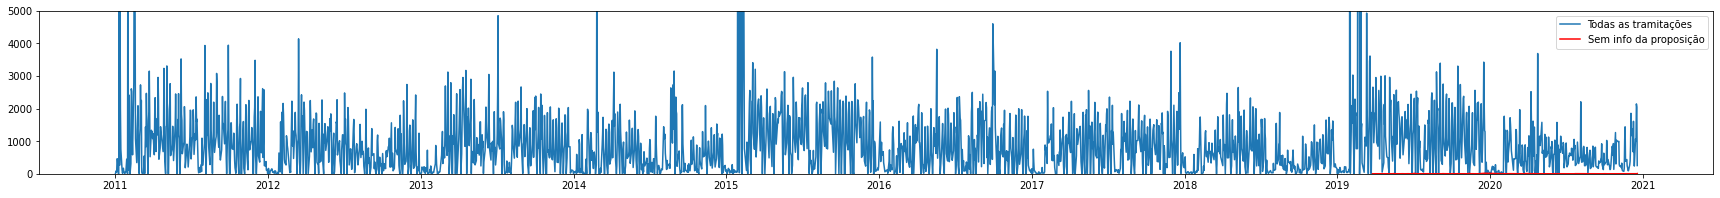

In [27]:
pl.figure(figsize=(30,3))
pl.plot(df_tramitacoes.data_hora.dt.date.value_counts().sort_index(), label='Todas as tramitações')
pl.plot(df_tramitacoes.loc[df_tramitacoes['siglaTipo'].isnull()].data_hora.dt.date.value_counts().sort_index(), color='r', label='Sem info da proposição')
pl.ylim([0, 5000])
pl.legend()
pl.show()

In [28]:
cols_interessantes_tramitacoes = ['data_hora', 'siglaOrgao', 'siglaTipo', 'ementa', 'descricaoTramitacao', 'despacho', 'eventos', 'n_eventos']

In [23]:
xu.checkMissing(df_tramitacoes)

Colunas com valores faltantes:
               coluna            N      %
1           siglaTipo          244   0.01
2              numero          244   0.01
3                 ano          244   0.01
4              ementa         2970   0.11
5           data_hora            1      0
6   descricaoSituacao  1.87195e+06  72.02
10          sequencia            1      0
11         siglaOrgao            1      0
13  id_prop_principal  1.86445e+06  71.73
14   uriPropPrincipal  1.86445e+06  71.73


### Aplicando regexes nas tramitações

O código abaixo classifica despachos da câmara em tipos de eventos identificados pelos regexes originais.

In [24]:
# Trocar False por True para rodar:
if True:
    n_eventos_total = len(camara_eventos)
    for i in range(n_eventos_total):

        # Get an evento-regex pair:
        evento = camara_eventos.iloc[i, 0]
        regex  = camara_eventos.iloc[i, 1]
        print('{}/{}: {}'.format(i + 1, n_eventos_total, evento), end=' - ')

        # Search for regex matches:
        match_regex = df_tramitacoes['despacho'].str.contains(regex, case=False)

        # Set eventos that match and count number of eventos:
        df_tramitacoes.loc[match_regex, 'eventos']   = df_tramitacoes.loc[match_regex, 'eventos'] + ' | ' + evento
        df_tramitacoes.loc[match_regex, 'n_eventos'] = df_tramitacoes.loc[match_regex, 'n_eventos'] + 1

1/45: aprovacao_parecer - 2/45: requerimento_redistribuicao - 3/45: requerimento_apensacao - 4/45: requerimento_urgencia_apresentado - 5/45: requerimento_urgencia_aprovado - 6/45: requerimento_prorrogacao - 7/45: aprovacao_requerimento_inversao_pauta - 8/45: projeto_reconstituido - 9/45: desarquivamento - 10/45: alteracao_de_regime - 11/45: distribuicao - 12/45: designado_relator - 13/45: voto_em_separado - 14/45: apresentacao_pl - 15/45: retirada_de_pauta - 16/45: aprovacao_requerimento_retirada_de_pauta - 17/45: pedido_de_vista - 

/home/skems/system/envs/gabi/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


18/45: inicio_prazo_emendas - 19/45: fim_prazo_emendas - 20/45: arquivamento - 21/45: parecer_pela_adequacao_financeira_e_orcamentaria - 22/45: parecer_pela_aprovacao_com_substitutivo - 23/45: parecer_pela_aprovacao - 24/45: parecer_pela_rejeicao - 25/45: virada_de_casa - 26/45: remetida_a_sancao_promulgacao - 27/45: transformada_lei - 28/45: vetada_totalmente - 29/45: parecer_comissao - 30/45: req_apresentacao - 31/45: req_deferido - 32/45: req_indeferido - 33/45: req_arquivado - 34/45: requerimento_adiamento_discussao - 35/45: requerimento_encerramento_discussao - 36/45: requerimento_comissao_especial - 37/45: parecer_pela_aprovacao_com_emenda - 38/45: nao_requer_avaliacao_financeira - 39/45: parecer_pela_inadequacao_financeira_e_orcamentaria - 40/45: parecer_pela_constitucionalidade - 41/45: aprovacao_redacao_final - 42/45: aprovacao_projeto - 43/45: cria_comissao_especial - 44/45: recebido_por_comissao - 45/45: requerimento_inclusao_em_pauta - 

In [32]:
# Salva identificação de eventos:
#df_tramitacoes.to_csv('../dados/eventos_identificados_em_tramitacoes_camara_desde_2011-01-01_regex_2021-02-20.csv', index=False, quoting=csv.QUOTE_ALL)

### Carregando tramitações já com eventos identificados

Como a identificação de eventos já foi feita e o resultado foi salvo, aqui podemos carregar o resultado.

In [18]:
df_tramitacoes = pd.read_csv('../dados/eventos_identificados_em_tramitacoes_camara_desde_2011-01-01_regex_2021-02-20.csv')
df_tramitacoes.loc[df_tramitacoes['eventos'].isnull(), 'eventos'] = ''
df_tramitacoes['data_hora'] = pd.to_datetime(df_tramitacoes['data_hora'])

### Avaliação dos regexes

**FAZER**

* Existem eventos que só estão listados para a câmara e outros que só estão listados para o senado. Se for isso mesmo, eu poderia replicar os regex que estão faltando. Na câmara, faltam: 'apresentacao_parecer', 'aprovacao_materia', 'aprovacao_projeto', 'aprovacao_substitutivo', 'comissao_instalada', 'designado_presidente_comissao', 'devolvido', 'incluida_ordem_dia', 'perda_da_eficacia', 'recebimento_comissao', 'rejeicao_projeto', 'requerimento_seminario'. No senado, faltam: 'alteracao_de_regime', 'aprovacao_requerimento_inversao_pauta', 'aprovacao_requerimento_retirada_de_pauta', 'comissao_especial', 'fim_prazo_emendas', 'inicio_prazo_emendas', 'parecer', 'parecer_comissao', 'projeto_reconstituido', 'redistribuicao', 'req_apresentacao', 'req_arquivado', 'req_deferido', 'req_indeferido', 'req_urgencia_unanime_verbal', 'requerimento_adiamento_discussao', 'requerimento_apensacao', 'requerimento_comissao_especial', 'requerimento_encerramento_discussao', 'requerimento_prorrogacao', 'requerimento_redistribuicao', 'requerimento_urgencia', 'voto_em_separado'. Talvez alguns estejam apenas com nomes diferentes e outros não possam ser replicados, mas certamente existem os que podem.

* Criar eventos de "pedido de retirada de proposição" e "retirada de proposição".

In [34]:
df_tramitacoes['n_eventos'].value_counts()

0    2147595
1     446005
2       5435
3        287
4         11
6          2
5          2
Name: n_eventos, dtype: int64

In [35]:
df_tramitacoes.loc[df_tramitacoes['n_eventos'] == 1, 'eventos'].value_counts(normalize=True)

 | designado_relator                                     0.153536
 | recebido_por_comissao                                 0.129095
 | arquivamento                                          0.086297
 | apresentacao_pl                                       0.071681
 | desarquivamento                                       0.065605
 | distribuicao                                          0.059347
 | fim_prazo_emendas                                     0.050141
 | parecer_pela_aprovacao                                0.046569
 | inicio_prazo_emendas                                  0.045771
 | retirada_de_pauta                                     0.045022
 | aprovacao_parecer                                     0.044578
 | parecer_comissao                                      0.033955
 | requerimento_inclusao_em_pauta                        0.029755
 | parecer_pela_constitucionalidade                      0.014038
 | parecer_pela_aprovacao_com_substitutivo               0.013605
 | aprovac

In [164]:
#sel = new_df_camara_leggo.loc[new_df_camara_leggo.evento.str.contains('parecer')]
#for e, r in zip(sel['evento'].values, sel['regex'].values):
#    print(xu.Bold(e))
#    print(r)
#    print('')

In [162]:
#print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains('parecer.*\Wadequação', case=False)].sample(10), True)

#### Teste de `aprovacao_redacao_final`

In [19]:
evento = 'aprovacao_redacao_final'
n_samples = 30

# Original:
current_regex  = 'dihyrgkdhkfh'
current_regex  = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,30}redação final'
sugestao_regex = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,30}redação final'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,7}redação final


In [20]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, n_samples, no_irrelevant=True)

Permanecem selecionados:     4809
     Novos selecionados:        0
Permanecem ignorados:     1794826
     Novos ignorados:           0


#### Criação de `retirada_pelo_autor`

In [28]:
evento = 'retirada_pelo_autor'
n_samples = 30

# Original:
current_regex  = '^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento)'
#current_regex  = '^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento)'
sugestao_regex = '^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento| ?d?o parecer)'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^retirad[ao] (?! ?o voto| ?o pedido de verificação| ?a verificação| ?[ao] (?:matéria|item)  ?de pauta| ?de pauta| ?os? destaques?| ?o dtq| ?a chancela| ?a emenda| ?o +requerimento|.{1,20},.{1,70}, o requerimento)


In [29]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, n_samples, no_irrelevant=True)

Permanecem selecionados:     2013
     Novos selecionados:        0
Permanecem ignorados:     1797621
     Novos ignorados:           1
Novos ignorados
2012-03-27 (CDEICS) PLP90/11 - Notificações - temp_old_regex
Retirada do parecer pelo Relator, mantendo válido o parecer apresentado no dia 19/10/2011, pela rejeição.



In [163]:
despacho = 'Retirado de tramitação, conforme Art. 104 do RICD, a pedido do Autor (Ofício nº 059/2016 - GDHL/BSB).'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 1)

Found 2 proposições. Printing for # 1
2016-06-29 00:00:00 (CPIDPVAT) - REQ10/16 - Arquivamento
Retirado de tramitação, conforme Art. 104 do RICD, a pedido do Autor (Ofício nº 059/2016 - GDHL/BSB).
2016-06-20 17:34:00 (CPIDPVAT) - REQ10/16 - Apresentação de Proposição
Apresentação do Requerimento n. 10/2016, pelo Deputado Hugo Leal (PSB-RJ), que: "Requer, nos termos do art. 36, inciso II, do Regimento Interno da Câmara dos Deputados, a convocação do Sr. Fernando Velloso, Delegado da Polícia Civil no Estado do Rio de Janeiro, para prestar depoimento perante esta Comissão Parlamentar de Inquérito".


#### Criação de `recebido_por_comissao`

In [62]:
camara_eventos.loc[camara_eventos['evento'] == evento, 'regex']

Series([], Name: regex, dtype: object)

In [89]:
evento = 'requerimento_urgencia_apresentado'
n_samples = 30

# Original:
current_regex  = 'djhbedlgjbdvs'
sugestao_regex = 'encaminhado à\(ao\) (?![a-z]{2,7}\(sgm\)|ccp |cedenun|secap|najur|natec|seaut|secod|sgm|coap|arquivo|serco|mesa|aplen|1secm|secad|sexpe|sindinfo|serau|seram|sepro|1vipr|secav|serad|coetica|compi|par|gtcl|cpc |mercosul|sedhi)'
sugestao_regex = '^recebi.{2,10}pel(?!.*(?:[a-z]{2,7}\(sgm\)|ccp[.,;: ]|cedenun|secap|najur|natec|seaut|secod|sgm|coap|arquivo|serco|mesa|aplen|1secm|secad|sexpe|sindinfo|serau|seram|sepro|1vipr|secav|serad|coetica|compi|par|gtcl|cpc[\.,;: ]|mercosul|sedhi))'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: apresentação d[ao] requerimento de urg[eê]ncia


In [90]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, n_samples, no_irrelevant=True)

Permanecem selecionados:        0
     Novos selecionados:    52467
Permanecem ignorados:     1747168
     Novos ignorados:           0
Novos selecionados
2012-08-01 (CCJC) PDC602/12 - Recebimento
Recebimento pel a CCJC.

2015-10-28 (CMADS) PL2304/15 - Recebimento
Recebimento pela CMADS.

2014-04-09 (CCJC) PL7323/14 - Recebimento
Recebimento pela CCJC.

2019-03-22 (CCJC) PL1297/19 - Recebimento
Recebimento pela CCJC.

2012-11-22 (CME) PL4109/12 - Recebimento
Recebimento pela CME.

2018-01-08 (CCULT) PL9230/17 - Recebimento
Recebimento pela CCULT.

2015-03-04 (CCJC) PLP3/15 - Recebimento
Recebimento pela CCJC.

2019-11-27 (CME) PL5822/19 - Recebimento
Recebimento pela CME.

2013-11-06 (CCJC) PDC1367/13 - Recebimento
Recebimento pela CCJC.

2017-12-11 (CCJC) PL673/07 - Recebimento
Recebimento pela CCJC.

2015-04-13 (CCJC) PL953/15 - Recebimento
Recebimento pela CCJC.

2017-04-24 (CIDOSO) PL5093/09 - Recebimento
Recebimento pela CIDOSO, apensado ao PL-4969/2005

2018-12-13 (CCJC) PLP247/1

#### Criação de `requerimento_inclusao_em_pauta`

In [34]:
#sel = df_tramitacoes.loc[df_tramitacoes['descricaoTramitacao'] == 'Inclusão em Pauta']
sel = df_tramitacoes.loc[df_tramitacoes['eventos'].str.contains('requerimento_inclusao_em_pauta')]
print(len(sel))

13383


In [39]:
print_despachos(sel.sample(3), True)

2013-12-04 (PLEN) PL7291/06 - Apresentação de Requerimento - requerimento_inclusao_em_pauta
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 9175/2013, pelo Deputado Antonio Bulhões (PRB-SP), que: "Requeiro a inclusão do Projeto de Lei n° 7.291/2006, que trata da proibição de animais em circos, na pauta da Ordem do Dia".

2011-09-21 (PLEN) REQ3283/11 - Apresentação de Proposição - requerimento_inclusao_em_pauta
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 3283/2011, pelo Deputado Jhonatan de Jesus (PRB-RR), que: "Requer a inclusão na pauta da Ordem do Dia do Plenário, do Projeto de Lei  nº 7749/2010 que dispõe sobre o subsídio de Ministro do Supremo Tribunal Federal, referido no art. 48, XV, da Constituição Federal, e dá outras providências".

2014-03-25 (PLEN) REQ9779/14 - Apresentação de Proposição - requerimento_inclusao_em_pauta
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 9779/2014, pelo Deputado Roberto Britto (PP-BA), que: "Requer a inclu

In [32]:
evento = 'requerimento_urgencia_apresentado'
n_samples = 10

# Original:
current_regex  = '^apresent.*(?:inclusão|incluir?).{1,20}(?:pauta|ordem)'
sugestao_regex = '^apresent.*(?:inclusão|incluir?).{1,30}(?:pauta|ordem)'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: apresentação d[ao] requerimento de urg[eê]ncia


In [33]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:    13320
     Novos selecionados:       19
Permanecem ignorados:     1786296
     Novos ignorados:           0
Novos selecionados
2012-10-09 (CAPADR) REQ264/12 - Apresentação de Proposição - requerimento_inclusao_em_pauta
Apresentação do Requerimento n. 264/2012, pelo Deputado Raimundo Gomes de Matos (PSDB-CE), que: "Solicita inclusão do Requerimento nº 262/12 na pauta para votação imediata".

2014-05-28 (CTUR) REQ363/14 - Apresentação de Proposição - requerimento_inclusao_em_pauta
Apresentação do Requerimento n. 363/2014, pelo Deputado Renato Molling (PP-RS), que: "Requer, nos termos regimentais, inclusão de requerimento extrapauta, para realização de audiência pública na Comissão de Turismo da Câmara dos Deputados para discutir o desenvolvimento do turismo regional no país".

2012-12-13 (PLEN) REQ6578/12 - Apresentação de Proposição - requerimento_inclusao_em_pauta
Apresentação do Requerimento n. 6578/2012, pelo Deputado Carlos Magno (PP-RO), que: ""Requer in

In [285]:
despacho = 'Apresentação do Requerimento de Inclusão na Ordem do Dia n. 10511/2014, pelo Deputado Arnaldo Faria de Sá (PTB-SP), que: "Requer inclusão na Ordem do Dia do PL nº 3299 de 2008".'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 1)

Found 2 proposições. Printing for # 1
2018-06-11 15:27:00 (CCP) - PL3299/08 - Notificação de Apensação
Apensação do PL 9900/2018 a esta proposição.
2018-06-07 10:42:00 (MESA) - PL3299/08 - Notificação de Apensação
Apense-se a este(a) o(a) PL-9900/2018.
2018-02-06 16:32:00 (PLEN) - PL3299/08 - Apresentação de Requerimento
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 8036/2018, pelo Deputado Arnaldo Faria de Sá (PTB-SP), que: "Requer inclusão na Ordem do Dia do PL nº 3299 de 2008".
2017-08-10 10:08:00 (PLEN) - PL3299/08 - Apresentação de Requerimento
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 6997/2017, pelo Deputado Arnaldo Faria de Sá (PTB-SP), que: "Requer inclusão na Ordem do Dia do PL nº 3299 de 2008".
2016-08-03 13:50:00 (PLEN) - PL3299/08 - Apresentação de Requerimento
Apresentação do Requerimento de Inclusão na Ordem do Dia n. 4972/2016, pelo Deputado Arnaldo Faria de Sá (PTB-SP), que: "Requer inclusão na Ordem do Dia do PL nº 3299 de 2008.".
2016-

#### Criação de `cria_comissao_especial`

In [254]:
sel = df_tramitacoes.loc[df_tramitacoes['descricaoTramitacao'] == 'Criação de Comissão Temporária']

In [255]:
print_despachos(sel.sample(10), True)

2013-04-18 (PLEN) PL3680/08 - Criação de Comissão Temporária
Ato da Presidência : Cria Comissão Especial, nos termos do inciso II e do § 1º do art. 34 do Regimento Interno.DCD de 19/04/13 PÁG 11528 COL 01.

2016-06-01 (PLEN) REQ4535/16 - Criação de Comissão Temporária
Ato da Presidência: Cria Comissão Externa, com ônus para a Câmara dos Deputados, destinada a fazer o acompanhamento e fiscalizar as investigações realizadas sobre o caso de estupro coletivo que ocorreu na cidade do Rio de Janeiro.

2018-03-05 (SERCO(SGM)) REQ8067/18 - Criação de Comissão Temporária
Ato da Presidência: Cria Comissão Externa, nos termos do art. 38 do Regimento Interno.

2018-03-14 (PLEN) PEC383/17 - Criação de Comissão Temporária
Ato da Presidência: Cria Comissão Especial, nos termos do § 2º do art. 202 do Regimento Interno.

2016-09-14 (PLEN) PEC233/16 - Criação de Comissão Temporária
Ato da Presidência: Cria Comissão Especial, nos termos do § 2º do art. 202 do Regimento Interno.

2015-03-10 (PLEN) PEC491/

In [250]:
evento = 'requerimento_comissao_especial'
n_samples = 20

# Original:
current_regex  = '(?:criar?|constituir?|pela criação de) comissão especial'
sugestao_regex = '(?:criar?|constituir?|pela criação de) comissão especial'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: requerimento(s)* de constitui(c|ç)(a|ã)o de comiss(a|ã)o especial


In [251]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:      874
     Novos selecionados:        0
Permanecem ignorados:     1798761
     Novos ignorados:           0


In [177]:
print_examples(new_df_camara_leggo, df_tramitacoes, evento, print_headers=True)

requerimento_comissao_especial
requerimento(s)* de constitui(c|ç)(a|ã)o de comiss(a|ã)o especial

Matches
2015-06-11 (PLEN) REQ2125/15 - Apresentação de Proposição - requerimento_comissao_especial
Apresentação do Requerimento de Constituição de Comissão Especial de Estudo n. 2125/2015, pelo Deputado Valdir Colatto (PMDB-SC), que: "Requer a criação de Comissão Especial Por um Brasil sem burocracia destinada a atualizar a legislação brasileira, que engessa o setor produtivo e coloca em risco a competitividade internacional, elevando o valor da alimentação do consumidor brasileiro".

2015-03-05 (PLEN) PL2462/91 - Apresentação de Requerimento - requerimento_comissao_especial
Apresentação do Requerimento de Constituição de Comissão Especial de Projeto n. 808/2015, pelo Deputado João Campos (PSDB-GO), que: "Requer a constituição Comissão Especial para emitir Parecer ao Projeto de Lei 2.462/1991, e seus apensados, inclusive o PL 1.558/2011 que Dispõe sobre as organizações terroristas, de minh

In [243]:
despacho = 'Determino, de ofício, a desapensação do Projeto de Lei n. 1.374/2015 do Projeto de Lei n. 6.434/2013 e a sua apensação ao Projeto de Lei n. 5.236/2009, que tramita apensado ao Projeto de Lei n. 215/2007, nos termos do art. 142, caput, e do art. 143, inciso II, alínea “b”, do RICD. Em seguida, desapense-se o Projeto de Lei n. 6.434/2013 do Projeto de Lei n. 5.236/2009. Por conseguinte, distribua-se o Projeto de Lei n. 6.434/2013 às Comissões de Trabalho, de Administração e Serviço Público; de Agricultura, Pecuária, Abastecimento e Desenvolvimento Rural; de Seguridade Social e Família; de Meio Ambiente e Desenvolvimento Sustentável; de Finanças e Tributação (mérito e art. 54 do RICD); e de Constituição e Justiça e de Cidadania (art. 54 do RICD), sujeito à apreciação conclusiva pelas Comissões, art. 24, II, do RICD, e sob o regime de tramitação ordinário. Por versar a referida proposição matéria de competência de mais de três Comissões de mérito, consoante o disposto no art. 34, II, do RICD, decido pela criação de Comissão Especial.Publique-se.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 0)

Found 3 proposições. Printing for # 0
2020-03-12 14:00:00 (MESA) - PL5236/09 - Notificação de Apensação
Apense-se a este(a) o(a) PL-506/2020.
2019-07-30 16:16:00 (CCP) - PL5236/09 - Notificação de Apensação
Apensação do PL 4037/2019 a esta proposição.
2019-07-29 14:40:00 (MESA) - PL5236/09 - Notificação de Apensação
Apense-se a este(a) o(a) PL-4037/2019.
2019-03-11 15:19:00 (CCP) - PL5236/09 - Notificação de Apensação
Apensação do PL 949/2019 a esta proposição.
2019-03-11 14:09:00 (MESA) - PL5236/09 - Notificação de Apensação
Apense-se a este(a) o(a) PL-949/2019.
2019-02-21 17:50:00 (MESA) - PL5236/09 - Desarquivamento a Pedido
Devido a desarquivamento desta proposição em requerimento anterior, foi declarada prejudicada a solicitação de desarquivamento constante do REQ-156/2019.
2019-02-20 19:44:00 (MESA) - PL5236/09 - Desarquivamento a Pedido
Devido a desarquivamento desta proposição em requerimento anterior, foi declarada prejudicada a solicitação de desarquivamento constante do REQ-

#### Análise de `virada_de_casa`

In [169]:
evento = 'virada_de_casa'
n_samples = 20

# Original:
current_regex  = '^reme.{1,35}senado'
sugestao_regex = '^remes.{1,35}senado'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: (^(remessa|remetido) ao senado federal.*)|(recebido o ofício.* do sf, que comunico que o senado federal aprovou, em revisão.*)


In [170]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:     4777
     Novos selecionados:        0
Permanecem ignorados:     1794858
     Novos ignorados:           0


In [131]:
print_examples(new_df_camara_leggo, df_tramitacoes, evento, print_headers=True)

virada_de_casa
(^(remessa|remetido) ao senado federal.*)|(recebido o ofício.* do sf, que comunico que o senado federal aprovou, em revisão.*)

Matches
2014-04-02 (MESA) PL3405/97 - Remessa ao Senado Federal - virada_de_casa
Remessa ao Senado Federal por meio do Of. nº 67/14/PS-GSE.

2011-06-08 (MESA) PL7625/10 - Remessa ao Senado Federal - virada_de_casa
Remessa ao Senado Federal através do Of. nº 114/11/PS-GSE.

2019-08-21 (MESA) PDC1556/14 - Remessa ao Senado Federal - virada_de_casa
Remessa ao Senado Federal por meio do Of. nº 209/19/PS-GSE.

2018-10-25 (MESA) PDC619/17 - Remessa ao Senado Federal - virada_de_casa
Remessa ao Senado Federal por meio do Of. nº 1.127/18/SGM-P.

2012-12-10 (MESA) PDC622/12 - Remessa ao Senado Federal - virada_de_casa
Remessa ao Senado Federal por meio do Of. nº 735/12/PS-GSE.



In [145]:
despacho = 'Remessa dos Autógrafos ao Senado Federal por meio do Of. nº 1.117/18/SGM-P.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 0)

2018-10-24 00:00:00 (MESA) - PL1060/15 - Remessa ao Senado Federal
Remessa dos Autógrafos ao Senado Federal por meio do Of. nº 1.117/18/SGM-P.
2018-10-18 16:15:00 (SEAUT(SGM)) - PL1060/15 - Recebimento
Recebimento pela SEAUT(SGM).
2018-10-18 15:36:00 (CCJC) - PL1060/15 - Encaminhamento
Encaminhado à(ao) SEAUT(SGM) através da guia de Remessa (GR/CCJC) nº 1004/2018.
2018-10-17 10:00:00 (CCJC) - PL1060/15 - Aprovação da Redação Final
Aprovada a Redação Final.
2018-08-13 18:54:00 (CCJC) - PL1060/15 - Recebimento - Redação Final
Apresentação da Redação Final n. 1 CCJC, pelo Deputado Fábio Trad (PSD-MS).
2018-08-13 00:00:00 (CCJC) - PL1060/15 - Designação de Relator
Designado Relator da Redação Final, Dep. Fábio Trad (PSD-MS)
2018-07-18 14:16:00 (CCJC) - PL1060/15 - Recebimento
Recebimento pela CCJC.
2018-07-18 09:43:00 (CCP) - PL1060/15 - Encaminhamento
Encaminhado à(ao) CCJC através da guia de Remessa (GR/CCP) nº 14545/2018.
2018-07-18 09:40:00 (CCP) - PL1060/15 - Recebimento
Recebimento p

#### Análise de `requerimento_urgencia`

In [113]:
evento = 'requerimento_urgencia'
n_samples = 20

# Original:
current_regex  = '^apresentação do requerimento de urgência'
sugestao_regex = 'apresentação d[ao] requerimento de urg[eê]ncia'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^apresentação do requerimento de urgência


In [114]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:     2844
     Novos selecionados:      136
Permanecem ignorados:     1796655
     Novos ignorados:           0
Novos selecionados
2011-11-18 (PLEN) REQ3810/11 - Apresentação de Proposição
Apresentação da Requerimento de Urgência (Art. 155 do RICD) n. 3810/2011, pelo Líderes, que: "Requer urgência para apreciação do Projeto de Lei nº 1.597, de 2011".

2011-10-05 (PLEN) PL7495/06 - Apresentação de Requerimento
Apresentação da Requerimento de Urgencia (Art. 154 do RICD) n. 3435/2011, pelo Deputado Raimundo Gomes de Matos (PSDB-CE), que: "requerimento de urgência ao projeto de lei 7495/2006".

2011-12-14 (PLEN) REQ4075/11 - Apresentação de Proposição
Apresentação da Requerimento de Urgência (Art. 155 do RICD) n. 4075/2011, pelo Deputado Nelson Marquezelli (PTB-SP), que: "Requer urgência para apreciação do Projeto de Lei nº  6613, de 2009.".

2012-06-13 (PLEN) REQ5525/12 - Apresentação de Proposição
Apresentação da Requerimento de Urgência (Art. 155 do RICD) n. 5525

In [99]:
print_examples(new_df_camara_leggo, df_tramitacoes, evento, print_headers=True)

requerimento_urgencia
^apresentação do requerimento de urgência

Matches
2017-12-13 (PLEN) PL7683/14 - Apresentação de Requerimento - requerimento_urgencia_apresentado | requerimento_urgencia
Apresentação do Requerimento de Urgência (Art. 155 do RICD) n. 7937/2017, pelo Deputado Jhc (PSB-AL), que: "Requer urgência para apreciação PL 7683/2014, que dispõe sobre a Organização da Justiça Militar da União e da regulação e funcionamento de seus Serviços Auxiliares".

2020-07-03 (MESA) REQ1755/20 - Apresentação de Proposição - requerimento_urgencia_apresentado | requerimento_urgencia
Apresentação do Requerimento de Urgência (Art. 155 do RICD) n. 1755/2020, pela Deputada Carmen Zanotto  (CIDADANIA/SC) e outros, que "Requer, nos termos do artigo 155 do Regimento Interno, tramitação sob o regime urgência do Projeto de Lei nº. 2270/2020".

2016-08-23 (PLEN) PL5230/13 - Apresentação de Requerimento - requerimento_urgencia_apresentado | requerimento_urgencia
Apresentação do Requerimento de Urgênci

In [100]:
despacho = 'Apresentação do Requerimento de Urgência (Art. 155 do RICD) n. 703/2019, pelo Líderes, que: "Requer urgência para o Projeto de Lei (PL) n. 899, de 2019.".'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 0)

Found 2 proposições. Printing for # 0
2019-04-08 17:19:00 (MESA) - PL899/19 - Notificação de Apensação
Apense-se a este(a) o(a) PL-1732/2019.
2019-03-26 17:33:00 (PLEN) - PL899/19 - Apresentação de Requerimento
Apresentação do Requerimento de Constituição de Comissão Especial de Projeto n. 956/2019, pelo Deputado Fábio Faria (PSD-RN), que: "Requer a criação de Comissão Especial a fim de debater o PL 899/2019 que Altera o Estatuto da Criança e do Adolescente, Lei nº 8.069, de 13 de julho de 1990, para dispor sobre a apresentação de aviso de classificação etária dos conteúdos audiovisuais disponibilizados nas plataformas de compartilhamento de vídeos na internet".
2019-03-12 16:04:00 (PLEN) - PL899/19 - Apresentação de Requerimento
Apresentação do Requerimento de Urgência (Art. 155 do RICD) n. 703/2019, pelo Líderes, que: "Requer urgência para o Projeto de Lei (PL) n. 899, de 2019.".
2019-03-01 00:00:00 (CCP) - PL899/19 - Publicação de Proposição
Encaminhada à publicação. Publicação Inic

#### Análise de `remetida_a_sancao_promulgacao`

In [89]:
evento = 'remetida_a_sancao_promulgacao'
n_samples = 20

# Original:
current_regex  = '(projeto( foi|) encaminhado à sanção presidencial)|(remessa à sanção.*)|(à promulga..o)|(remessa da mat(é|e)ria à sanção.*)'
sugestao_regex = 'projeto(?: foi|) encaminhado à sanção presidencial|remessa à sanção|à promulga..o|remessa da mat[ée]ria à sanção'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: (projeto( foi|) encaminhado à sanção presidencial)|(remessa à sanção.*)|(à promulga..o)|(remessa da mat(é|e)ria à sanção.*)


In [90]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:     1239
     Novos selecionados:        0
Permanecem ignorados:     1798396
     Novos ignorados:           0


In [78]:
print_examples(new_df_camara_leggo, df_tramitacoes, evento, print_headers=True)

remetida_a_sancao_promulgacao
(projeto( foi|) encaminhado à sanção presidencial)|(remessa à sanção.*)|(à promulga..o)|(remessa da mat(é|e)ria à sanção.*)

Matches
2013-04-16 (MESA) MPV587/12 - Recebimento - remetida_a_sancao_promulgacao
Recebimento do Ofício nº 240/13 (CN) comunicando remessa à sanção.

2011-04-28 (MESA) PL74/03 - Recebimento - remetida_a_sancao_promulgacao
Recebimento do Ofício nº 481/11(SF) comunicando remessa à sanção.

2017-12-14 (MESA) PL8965/17 - Recebimento - remetida_a_sancao_promulgacao
Recebimento do Ofício nº 1391/2017 (SF) comunicando remessa à sanção.

2012-06-29 (MESA) PL1089/03 - Remessa à Sanção - remetida_a_sancao_promulgacao
Remessa à sanção através da Mensagem nº 23/12.

2013-10-14 (MESA) PL3078/11 - Recebimento - remetida_a_sancao_promulgacao
Recebimento do Ofício nº 2.208/13(SF) comunicando remessa à sanção.



In [74]:
despacho = 'A matéria vai à promulgação (PRC 14-B/1999).DCD de 30/10/15 PÁG 66 COL 01.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 0)

2015-12-31 00:00:00 (MESA) - PRC14/99 - Matéria apreciada em Plenário
Matéria deliberada em Plenário
2015-12-16 11:12:00 (ARQUIVO) - PRC14/99 - Arquivamento
Arquivada pelo ARQUIVO através da Guia de Transferência GTP nº 2/2015 - SERAU(SGM). Nº de Volume(s): 1. Caixa(s): 15
2015-12-16 11:06:00 (ARQUIVO) - PRC14/99 - Arquivamento
Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 2/2015 - SERAU(SGM). Nº de Volume(s): 1. Caixa(s): 15
2015-12-16 11:00:00 (SERAU(SGM)) - PRC14/99 - Arquivamento
Encaminhada ao ARQUIVO através da Guia de Transferência GTP nº 2/2015 - SERAU(SGM). Nº de Volume(s): 1. Caixa(s): 15
2015-12-16 10:40:00 (SERAU(SGM)) - PRC14/99 - Arquivamento
Devolvida pelo ARQUIVO ao órgão de origem para correções na Guia de Transferência GTP nº 2/2015 - SERAU(SGM). Nº de Volume(s): 1. Caixa(s): 15
2015-12-16 10:39:00 (ARQUIVO) - PRC14/99 - Arquivamento
Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 2/2015 - SERAU(SGM). Nº de

#### Análise de `alteracao_de_regime`

In [48]:
evento = 'alteracao_de_regime'
n_samples = 20

# Original:
current_regex  = 'alteração do regime de tramitação desta proposição'
sugestao_regex = 'altera(?:ção|do|da) d?o regime de tramitação dest[aa] (?:proposi..o|prosposta|projeto)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^alteração do regime de tramitação desta proposição


In [49]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:      639
     Novos selecionados:        0
Permanecem ignorados:     1798996
     Novos ignorados:           0


In [47]:
despacho = 'Defiro o pedido contido no Requerimento n. 9.852/2014. Apense-se o Projeto de Lei n. 2.833/2011 ao Projeto de Lei n. 7.199/2010, que tramita apensado ao Projeto de Lei n. 4.548/1998, nos termos do art. 142 e do art. 143, inciso II, alínea “b”, do Regimento Interno da Câmara dos Deputados - RICD. Determino, por conseguinte, a alteração do regime de tramitação do Projeto de Lei n. 4.548/1998 e seus apensos para urgência do art. 155 do RICD, nos termos do art. 143, parágrafo único, do RICD. Publique-se.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 2)

Found 5 proposições. Printing for # 2
2019-02-22 18:30:00 (MESA) - PL4548/98 - Desarquivamento a Pedido
Devido a desarquivamento desta proposição em requerimento anterior, foi declarada prejudicada a solicitação de desarquivamento constante do REQ-408/2019.
2019-02-22 18:27:00 (MESA) - PL4548/98 - Desarquivamento a Pedido
Devido a desarquivamento desta proposição em requerimento anterior, foi declarada prejudicada a solicitação de desarquivamento constante do REQ-408/2019.
2019-02-21 17:50:00 (MESA) - PL4548/98 - Reentrada na comissão por arquivamento
Reentrada na comissão por motivo de desarquivamento
2019-02-21 17:50:00 (MESA) - PL4548/98 - Desarquivamento a Pedido
Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-156/2019.
2019-01-31 00:00:00 (MESA) - PL4548/98 - Arquivamento
Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.
2015-04-28 00:00:00 (MESA) - PL4548/98 - Notificação de Despacho
Despacho exarado ao R

#### Análise de `parecer_comissao`

In [223]:
evento = 'parecer_comissao'
n_samples = 20

# Original:
current_regex  = '^encaminhada à publicação. parecer da comissão.*'
sugestao_regex = 'encaminhad[oa] [aà] publicação. parecer da comissão'
sugestao_regex = 'encaminhada à publicação.*parecer da comissão'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^encaminhada à publicação. parecer da comissão.*


In [224]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:    14870
     Novos selecionados:       10
Permanecem ignorados:     1784755
     Novos ignorados:           0
Novos selecionados
2013-03-11 (CCP) PDC561/12 - Publicação de Proposição
Encaminhada à publicação. Letra A. Parecer da Comissão de Viação e Transportes e da Comissão de Constituição e Justiça e de Cidadania publicado em Avulso. Pendente de parecer da CFT.

2017-08-15 (CCP) PEC77/03 - Publicação de Proposição
Encaminhada à publicação (PEC 77-C/03). Parecer da Comissão Especial publicado em avulso e em Suplemento ao 118. DCD de 16/08/17 PÁG 03 COL 01. VOL II..

2013-10-08 (CCP) PLP51/07 - Publicação de Proposição
Encaminhada à publicação. Emendas de Plenário e Parecer da Comissão de Trabalho, de Administração e Serviço Público Publicado no DCD de DCD de 09/10/13 PAG 46487 COL 02, Letra A.

2013-08-21 (CCP) PL6020/13 - Publicação de Proposição
Encaminhada à publicação. Emenda de Plenário e Parecer da Comissão de Constituição e Justiça e de Cidadania Publi

In [222]:
despacho = 'Encaminhada à publicação, com parecer da Comissão Mista, publicado em avulso e no DCD de 05/09/12 PÁG 03 COL 01,  Suplemento.'
print_tramitacao_w_despacho(df_tramitacoes, despacho)

2014-08-12 00:00:00 (MESA) - MPV571/12 - Encaminhamento
Envio ao Arquivo Intermediário. Aguardando deliberação de veto.
2014-08-12 00:00:00 (MESA) - MPV571/12 - Encaminhamento
Envio ao Arquivo Intermediário. Aguardando deliberação de veto.
2012-12-07 00:00:00 (MESA) - MPV571/12 - Recebimento
Recebimento do Of. nº 526/12 (CN) comunicando término do prazo p/apresentação de PDC e a consequente extinção da Comissão Mista destinada a examinar a matéria.
2012-12-07 00:00:00 (MESA) - MPV571/12 - Recebimento
Recebimento do Of. nº 526/12 (CN) comunicando término do prazo p/apresentação de PDC e a consequente extinção da Comissão Mista destinada a examinar a matéria.
2012-11-13 00:00:00 (PLEN) - MPV571/12 - Apresentação de Quadro Analítico
Apresentação de Quadro Analítico
2012-10-31 00:00:00 (MESA) - MPV571/12 - Recebimento
Recebimento do Ofício nº 466/12(CN) comunicando veto parcial e solicitando indicação de membros para integrar a Comissão Mista incumbida de relatar o(s) veto(s).
2012-10-31 0

#### Análise de `aprovacao_projeto`

In [190]:
evento = 'aprovacao_parecer'
n_samples = 20

# Original:
current_regex  = '(?<!pela )(?<! da |sua )(?<! [àa] )aprova.{1,7}(?:substitutivo|projeto|proposta)'
sugestao_regex = '(?<!pela )(?<! da |sua )(?<! [àa] )aprova.{1,7}(?:substitutivo|projeto|proposta)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*aprovado (o )*req)(?!aprovado o projeto).*(aprovado.*parecer|comiss.o aprova o relat.rio.*constituir o parecer|parecer.*aprovado pela comiss.o|comiss.o.*aprova o parecer|apresenta novo relat.rio.*comiss.o aprova|comiss.o aprova.*relat.rio|proferido.*o parecer.*aprovado o substitutivo|aprova..o do parecer d. relator.|aprovada a reda..o final assinada pel. relator).*$


In [189]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50, no_irrelevant=True)

Permanecem selecionados:     1034
     Novos selecionados:       20
Permanecem ignorados:     1798920
     Novos ignorados:           0
Novos selecionados
2011-10-18 (CSPCCO) REQ98/11 - Apresentação de Proposição
Apresentação do Requerimento n. 98/2011, pelo Deputado Alexandre Leite (DEM-SP), que: "Solicita realização de Audiência Pública, na Comissão de Segurança Pública e Combate ao Crime Organizado, a fim de debater-se a imprescindibilidade de aprovação da PEC nº 300, de 2008, bem como de suas apensadas, com a presença do Coronel e ex-Deputado Federal Jairo Paes de Lira, do Major e ex-Deputado Federal Fábio Rodrigues de Oliveira, e do Cabo da Polícia Militar Edison Burkert".

2013-05-14 (CCJC) PL6920/10 - Parecer do Relator - parecer_pela_constitucionalidade
Parecer do Relator, Dep. Danilo Forte (PMDB-CE), pela constitucionalidade, juridicidade, técnica legislativa e, no mérito, pela rejeição deste e aprovação do PL 807/2011, apensado.

2014-06-04 (CFT) PL5957/13 - Parecer do Relato

#### Análise de `aprovacao_parecer`

In [119]:
evento = 'aprovacao_parecer'
n_samples = 20

# Original:
current_regex  = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,7}(?:parecer|relatório|redação final)'
sugestao_regex = 'aprova(?!.{1,7}projeto).{1,9}(?:unan?im[ie]mente|un?[ia]nim[ei]dade|apreciação preliminar)?(?:com emendas)?(?:.{1,7}no Plenário do Congresso Nacional)?(?:.{1,20}votos.{1,20})?.{1,7}(?:parecer|relatório)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*aprovado (o )*req)(?!aprovado o projeto).*(aprovado.*parecer|comiss.o aprova o relat.rio.*constituir o parecer|parecer.*aprovado pela comiss.o|comiss.o.*aprova o parecer|apresenta novo relat.rio.*comiss.o aprova|comiss.o aprova.*relat.rio|proferido.*o parecer.*aprovado o substitutivo|aprova..o do parecer d. relator.|aprovada a reda..o final assinada pel. relator).*$


In [120]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 50)

Permanecem selecionados:    19920
     Novos selecionados:        0
Permanecem ignorados:     2574511
     Novos ignorados:        4906
Novos ignorados
2018-08-07 (PLEN) PL6852/13 - Aprovação de Proposição (Plenário) - temp_old_regex
Aprovada a Redação Final assinada pelo Relator, Dep. Orlando Silva (PCdoB-SP).

2012-08-07 (CCJC) PDC151/11 - Aprovação da Redação Final - temp_old_regex
Aprovada a Redação Final.

2018-06-07 (PLEN) PDC254/15 - Aprovação de Proposição (Plenário) - temp_old_regex
Aprovada a Redação Final, assinada pelo Relator, Dep. Paulo Teixeira (PT-SP).

2012-08-21 (PLEN) MPV565/12 - Aprovação de Proposição em Plenário - temp_old_regex
Aprovada a Redação Final assinada pelo Relator Revisor, Dep. Heleno Silva (PRB-SE).

2011-03-16 (CCJC) PDC2880/10 - Aprovação da Redação Final - temp_old_regex
Aprovada a Redação Final por Unanimidade.

2015-05-26 (CCJC) PDC1858/09 - Aprovação da Redação Final - temp_old_regex
Aprovada a Redação Final. Absteve-se de votar o Deputado Esperi

In [92]:
despacho = 'Aprovado o Substitutivo.'
print_tramitacao_w_despacho(df_tramitacoes, despacho)

2018-06-28 16:43:00 (ARQUIVO) - PL3763/04 - Arquivamento
Arquivada pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - SEAUT(SGM). Nº de Volume(s): 1. Caixa(s): 2
2018-06-28 15:57:00 (ARQUIVO) - PL3763/04 - Arquivamento
Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - SEAUT(SGM). Nº de Volume(s): 1. Caixa(s): 2
2018-06-28 15:40:00 (SEAUT(SGM)) - PL3763/04 - Arquivamento
Encaminhada ao ARQUIVO através da Guia de Transferência GTP nº 1/2018 - SEAUT(SGM). Nº de Volume(s): 1. Caixa(s): 2
2018-06-28 15:16:00 (SEAUT(SGM)) - PL3763/04 - Arquivamento
Devolvida pelo ARQUIVO ao órgão de origem para correções na Guia de Transferência GTP nº 1/2018 - SEAUT(SGM). Nº de Volume(s): 1. Caixa(s): 2
2018-06-28 15:14:00 (ARQUIVO) - PL3763/04 - Arquivamento
Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - SEAUT(SGM). Nº de Volume(s): 1. Caixa(s): 2
2018-05-28 16:45:00 (SEAUT(SGM)) - PL3763/04 - Arquivamento
Encaminhada a

In [51]:
print_examples(camara_eventos, df_tramitacoes, evento, 20, print_headers=True)

aprovacao_parecer
^(?!.*aprovado (o )*req)(?!aprovado o projeto).*(aprovado.*parecer|comiss.o aprova o relat.rio.*constituir o parecer|parecer.*aprovado pela comiss.o|comiss.o.*aprova o parecer|apresenta novo relat.rio.*comiss.o aprova|comiss.o aprova.*relat.rio|proferido.*o parecer.*aprovado o substitutivo|aprova..o do parecer d. relator.|aprovada a reda..o final assinada pel. relator).*$

Matches
2016-05-04 (CVT) PL5961/13 - Aprovação - aprovacao_parecer
Aprovado o Parecer.

2012-09-05 (CVT) PL7455/10 - Aprovação - aprovacao_parecer
Aprovado por Unanimidade o Parecer.

2011-04-06 (CREDN) MSC645/10 - Aprovação - aprovacao_parecer
Aprovado o Parecer.

2015-12-02 (CFT) PL5797/09 - Aprovação - aprovacao_parecer
Aprovado por Unanimidade o Parecer.

2013-06-05 (CCTCI) TVR322/13 - Aprovação - aprovacao_parecer
Aprovado por Unanimidade o Parecer.

2016-08-09 (CINDRA) PL3809/15 - Aprovação - aprovacao_parecer
Aprovado por Unanimidade o Parecer.

2012-05-23 (CFT) PL7330/10 - Aprovação - aprova

#### Análise de `retirada_de_pauta`

In [106]:
new_df_camara_leggo.loc[new_df_camara_leggo['evento']==evento, 'regex'].iloc[0]

'^retirad[oa] d[ea] pauta|aprova.*retirad[oa] d[ea] pauta'

In [107]:
evento = 'retirada_de_pauta'
n_samples = 20

# Original:
current_regex  = '^retirad[oa] d[ea] pauta|aprova.*retirad[oa] d[ea] pauta'
sugestao_regex = '^retirad[oa] (?:o item )?d[ea] pauta|aprova.*retirad[oa] d[ea] pauta'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^retirad[oa] d[ea] pauta|aprova.*retirad[oa] d[ea] pauta


In [108]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

Permanecem selecionados:    20646
     Novos selecionados:       21
Permanecem ignorados:     2578670
     Novos ignorados:           0
Novos selecionados
2017-09-20 (CCJC) PEC336/17 - Ratificação de Parecer
Retirado o item de pauta.

2017-08-09 (CCJC) PEC411/14 - Adiamento de Discussão
Retirado o item de pauta, de ofício, por acordo.

2017-07-11 (CCJC) PL8125/14 - Ratificação de Parecer
Retirado o item de pauta, de ofício, por acordo.

2017-12-12 (CCJC) PL1985/11 - Notificações
Retirado o item de pauta, de ofício, por acordo.

2017-06-28 (CCJC) PL6617/13 - Ratificação de Parecer
Retirado o item de pauta, de ofício, por acordo.

2017-06-28 (CCJC) PL3325/15 - Ratificação de Parecer
Retirado o item de pauta, de ofício, por acordo.

2019-09-10 (CCJC) PDC317/16 - Notificações
Retirado o item de pauta, de ofício, por acordo.

2017-06-28 (CCJC) PL3163/15 - Ratificação de Parecer
Retirado o item de pauta, de ofício, por acordo.

2017-06-28 (CCJC) PL1465/11 - Ratificação de Parecer
Retirado o 

In [475]:
print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains(sugestao_regex, case=False)].sample(10), True)

2013-10-23 (CFT) PL6214/09 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta em virtude da aprovação de requerimento do Deputado Afonso Florence.

2015-10-28 (CTASP) PL766/15 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta, "ex-officio".

2019-11-06 (CFT) PL3568/15 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta em virtude da ausência do Relator.

2014-04-02 (CCTCI) PL1247/11 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta pelo relator.

2015-06-10 (CDU) PL5858/13 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta a requerimento do deputado Hildo Rocha.

2013-06-26 (CDC) PL3769/04 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta, a pedido do Dep. Ubiali.

2012-05-16 (CE) PDC1142/08 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta a requerimento de deputado. (Izalci)

2017-03-08 (PLEN) REQ2524/15 - Retirada de Pauta - retirada_de_pauta
Retirado de pauta, de ofício.

2016-10-18 (CDU) PL6743/13 - Retirada de Pauta - retirada_d

In [479]:
find_despacho = 'Adiada a continuação da votação em face da aprovação do Requerimento que solicita retirada de pauta deste Projeto de Lei Complementar. DCD de 26/04/17 PÁG 38 COL 01.'
print_tramitacao_w_despacho(df_tramitacoes, find_despacho, 0)

2018-03-28 15:00:00 (ARQUIVO) - PLP343/17 - Arquivamento
Arquivada pelo ARQUIVO através da Guia de Transferência GTP nº 4/2018 - PLEN. Nº de Volume(s): 1. Caixa(s): 24
2018-03-27 18:30:00 (ARQUIVO) - PLP343/17 - Arquivamento
Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 4/2018 - PLEN. Nº de Volume(s): 1. Caixa(s): 24
2018-03-14 18:28:00 (PLEN) - PLP343/17 - Arquivamento
Encaminhada ao ARQUIVO através da Guia de Transferência GTP nº 4/2018 - PLEN. Nº de Volume(s): 1. Caixa(s): 24
2017-12-31 00:00:00 (MESA) - PLP343/17 - Matéria apreciada em Plenário
Matéria deliberada em Plenário
2017-08-15 09:14:00 (CCP) - PLP343/17 - Recebimento
Recebimento pela CCP.
2017-08-15 09:09:00 (CTASP) - PLP343/17 - Encaminhamento
Encaminhado à(ao) CCP através da guia de Remessa (GR/CTASP) nº 530/2017.
2017-08-11 00:00:00 (CTASP) - PLP343/17 - Devolução à CCP
Devolução à CCP
2017-05-23 00:00:00 (MESA) - PLP343/17 - Recebimento de autógrafos
Recebimento do Ofício nº 437/2017 (SF

#### Análise de `requerimento_urgencia_aprovado`

In [431]:
evento = 'requerimento_urgencia_aprovado'
n_samples = 20

# Original:
current_regex  = '^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|artigo) ?155)'
sugestao_regex = '^aprova(?!.*parecer).*(?:urg.ncia|(?:art\.|artigo) ?155)'
#sugestao_regex = '^aprova(?!.*parecer).*(?:urg.ncia)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^aprovado o requerimento de urg.ncia|aprovado, por unanimidade, o requerimento de urg.ncia


In [427]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

Permanecem selecionados:     1436
     Novos selecionados:       45
Permanecem ignorados:     2597856
     Novos ignorados:           0
Novos selecionados
2017-03-08 (CMULHER) PL3012/15 - Encerramento de Prazo
Encerramento automático o prazo para emendas ao projeto em virtude de aprovação de requerimento de urgência. Não foram apresentadas emendas.

2014-04-10 (PLEN) PL6295/13 - Discussão (Inicio e Continuacao)
Discussão em turno único (Aprovado o Requerimento de Urgência nº 9.989/2014).

2019-10-30 (GTPENAL) RRL1/19 - Aprovação de Proposição Interna
MEDIANTE ACORDO, DISCUSSÃO E VOTAÇÃO POR PARTES.SUBMETIDOS A VOTAÇÃO OS SEGUINTES DISPOSITIVOS DO TEXTO PROPOSTO PELO RELATOR, COM OS SEGUINTES RESULTADOS:1. Em relação ao artigo 3º do Substitutivo do Relator (Decreto-lei n.º 3689, de 3 de outubro de 1941 - Código de Processo Penal) APROVADO o art. 282, com alterações, nos seguintes termos – contra os votos do Deputado Capitão Augusto e da Deputada Adriana Ventura:“Art. 282 ...............

In [356]:
#print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains(sugestao_regex, case=False)].sample(3), True)

2020-03-25 (PLEN) PL786/20 - Notificações - req_urgencia_unanime_verbal
Por proposta verbal do Presidente ao Plenário, foi aprovado por unanimidade, em caráter excepcional, o requerimento de urgência, nos termos do art. 155, do Regimento Interno.

2020-03-25 (PLEN) PL805/20 - Notificações - req_urgencia_unanime_verbal
Por proposta verbal do Presidente ao Plenário, foi aprovado por unanimidade, em caráter excepcional, o requerimento de urgência, nos termos do art. 155 do Regimento Interno.

2020-03-25 (PLEN) PL9236/17 - Notificações - req_urgencia_unanime_verbal
Por proposta verbal do Presidente ao Plenário, foi aprovado por unanimidade, em caráter excepcional, requerimento de urgência, nos termos do art. 155, do Regimento Interno.



In [430]:
find_despacho = 'Por proposta verbal do Presidente ao Plenário, foi aprovado por unanimidade, em caráter excepcional, requerimento de urgência, nos termos do art. 155, do Regimento Interno.'
print_tramitacao_w_despacho(df_tramitacoes, find_despacho, 3)

2020-04-02 00:00:00 (SEXPE(SGM)) - PL9236/17 - Notificação de Encaminhamento Fora de Fluxo
Encaminhar ao Arquivo
2020-04-02 00:00:00 (MESA) - PL9236/17 - Transformado em Norma Jurídica com Veto Parcial
Transformado na Lei Ordinária 13982/2020. DOU 02/04/20 PÁG 01 COL 01 -  EDIÇÃO EXTRA. Vetado parcialmente. (MSC 141/20-PE). Razões do veto: DOU 02/04/20 PÁG 03 COL 01 - EDIÇÃO EXTRA.
2020-03-30 11:21:00 (MESA) - PL9236/17 - Publicação de Proposição
Encaminhamento de Despacho de Distribuição à CCP para publicação.
2020-03-30 11:20:00 (PLEN) - PL9236/17 - Encaminhamento
Despacho Chancelado
2020-03-30 00:00:00 (MESA) - PL9236/17 - Distribuição
Em virtude de inexatidão material constante no texto dos autógrafos do Projeto de Lei nº 9.236, de 2017, encaminhado em 27/03/2020, por meio do Of. nº 199/2020/SGM-P, proceda-se às devidas correções, nos termos do art. 199 do Regimento Interno da Câmara dos Deputados. Publique-se.
2020-03-30 00:00:00 (MESA) - PL9236/17 - Remessa ao Senado Federal
Reme

#### Análise de `aprovacao_requerimento_retirada_de_pauta`

In [346]:
evento = 'aprovacao_requerimento_retirada_de_pauta'
n_samples = 20

# Original:
current_regex  = 'aprova.*(?:retirada (?:de pauta|de tramitação|do projeto|d[ea] ordem do dia|dest[ae]|de proposição)|requerimento de retirada)'
sugestao_regex = 'aprova.*(?:retirada (?:de pauta|de tramitação|do projeto|d[ea] ordem do dia|dest[ae]|de proposição)|requerimento de retirada)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: aprovado o* requerimento de retirada de pauta


In [343]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:      200
     Novos selecionados:      405
Permanecem ignorados:     2598732
     Novos ignorados:           0
Novos selecionados
2017-11-08 (CCJC) PLP1/15 - Notificações
Aprovado o Requrimento de Retirada de Pauta.

2013-07-02 (PLEN) REQ8093/13 - Prejudicado
Prejudicado em face da aprovação do Requerimento nº 8.100, de 2013, do Dep. João Campos, que "Requer a retirada de tramitação do Projeto de Decreto Legislativo nº 234/2011.DCD de 03/07/13, PÁG 27687 COL 02.

2011-03-24 (PLEN) PDC415/03 - Retirada pelo Autor
Aprovada a Mensagem nº 462/04, do Poder Executivo, que solicita a retirada deste Projeto.

2017-06-13 (CMADS) PL4663/16 - Retirada de Pauta
Aprovado Requerimento de Retirada de pauta do Deputado Leonardo Monteiro.

2012-05-22 (CCJC) PL7292/06 - Retirada de Pauta
Aprovado requerimento de retirada de pauta apresentado pelo Deputado Marcos Rogério.

2011-07-06 (CCJC) PL2889/97 - Retirada de Pauta
Aprovado Requerimento de Retirada de Pauta, apresentado pelo

In [339]:
#print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains(sugestao_regex, case=False)].sample(20), True)

2014-07-02 (CMADS) PL4123/12 - Retirada de Pauta
Aprovado requerimento de retirada de pauta, do Deputado Leonardo Monteiro.

2012-03-28 (CMADS) PL62/11 - Retirada de Pauta
Aprovado requerimento de retirada de pauta.

2019-09-18 (CDU) PL2591/19 - Retirada de Pauta
Aprovado requerimento de retirada de pauta do deputado ricardo pericar (PSL/RJ).

2016-10-19 (CCJC) PL3330/15 - Ratificação de Parecer
Aprovado o Requerimento de Votação Nominal para o Requerimento de Retirada de Pauta, com voto contrário do Deputado Alessandro Molon.

2015-08-12 (CCJC) PL7971/10 - Ratificação de Parecer - aprovacao_requerimento_retirada_de_pauta
Aprovado o Requerimento de Retirada de Pauta.

2017-10-31 (CCJC) PEC336/17 - Ratificação de Parecer
Aprovado Requerimento de Retirada de Pauta.

2015-07-14 (CCJC) PRC40/15 - Ratificação de Parecer - aprovacao_requerimento_retirada_de_pauta
Verificação conjunta de votação do Requerimento de Retirada de Pauta solicitada pelo Deputado Índio da Costa, Vice-Líder do PSD, e

In [335]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

Permanecem selecionados:      605
     Novos selecionados:        0
Permanecem ignorados:     2598732
     Novos ignorados:           0


In [266]:
find_despacho = 'Retirado de pauta pelo autor.'
print_tramitacao_w_despacho(df_tramitacoes, find_despacho, 3)

Found 552 proposições. Printing for # 3
2017-02-14 14:30:00 (CPIROUAN) - REQ51/16 - Retirada de Pauta
Retirado de pauta pelo autor.
2016-10-11 09:30:00 (CPIROUAN) - REQ51/16 - Não Deliberado
Não Deliberado
2016-10-04 14:30:00 (CPIROUAN) - REQ51/16 - Não Deliberado
Não Deliberado
2016-09-26 11:07:00 (CPIROUAN) - REQ51/16 - Apresentação de Proposição
Apresentação do Requerimento n. 51/2016, pelo Deputado Izalci (PSDB-DF), que: "Requer, em sintonia com as disposições constitucionais, legais e regimentais, seja CONVOCADO o Sr. CHRISTOPHER PODGORSKI, presidente da operação brasileira da Scania no Brasil para prestar depoimento".


#### Análise de `aprovacao_requerimento_inversao_pauta`

In [166]:
evento = 'aprovacao_requerimento_inversao_pauta'
n_samples = 30

# Original:
current_regex  = '^.*aprovado o requerimento.*invers.o de pauta.*$'
sugestao_regex = '^.*aprovado o requerimento.*invers.o de pauta.*$'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^.*aprovado o requerimento.*invers.o de pauta.*$


In [167]:
print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains(sugestao_regex, case=False)].sample(20), True)

2018-05-23 (CSPCCO) PL6978/17 - Aprovação de Requerimento Procedimental - aprovacao_requerimento_inversao_pauta
Aprovado o Requerimento de Inversão de Pauta.

2017-02-20 (PLEN) PL3792/15 - Aprovação de Proposição em Plenário - aprovacao_requerimento_inversao_pauta
Aprovado o Requerimento do Dep. Afonso Motta (PDT-RS), na qualidade de Líder do PDT, que solicita inversão de pauta, a fim de que o PL 742/2011, item 10 da pauta, seja apreciado como o item 1, renumerando-se os demais.

2016-03-03 (PLEN) PL3834/15 - Aprovação de Proposição em Plenário - aprovacao_requerimento_inversao_pauta
Aprovado o Requerimento do Dep. Wadih Damous, na qualidade de Líder do Governo, que solicita inversão de pauta, a fim de que as matérias dela constantes sejam apreciadas na seguinte ordem: 1º) PL 3.834/2015, seguido dos demais itens. 

2017-02-16 (PLEN) PDC424/16 - Aprovação de Proposição em Plenário - aprovacao_requerimento_inversao_pauta
Aprovado o Requerimento da Dep. Erika Kokay, que solicita inversão 

In [168]:
#compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

#### Análise de `parecer_pela_inconstitucionalidade`

In [160]:
evento = 'parecer_pela_aprovacao'
n_samples = 30

# Original:
current_regex  = 'parecer(?! às? emenda).* (?:injuridicidade|(?:má|inadequada) técnica legislativa(?:\.| deste))'
sugestao_regex = 'parecer(?! às? emenda).* (?:injuridicidade|(?:má|inadequada) técnica legislativa(?:\.| deste))(?!.* juridicidade).*'
sugestao_regex = 'parecer(?! às? emenda).* injuridicidade'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)


In [162]:
print_despachos(df_tramitacoes.loc[df_tramitacoes.despacho.str.contains(sugestao_regex, case=False)].sample(20), True)

2016-10-04 (CCJC) PL7239/10 - Parecer do Relator
Parecer do Relator, Dep. Esperidião Amin (PP-SC), pela constitucionalidade, juridicidade e técnica legislativa deste, com emenda da redação, do PL 1875/2007, do PL 495/2011, do PL 6123/2013, do PL 3768/2015, com emendas de constitucionalidade, do PL 65/2007, do PL 246/2007, do PL 1058/2007,  do PL 2361/2007, do PL 2749/2008, do PL 2750/2008, do PL 5794/2009, do PL 7670/2010, do PL 566/2011, do PL 952/2011, do PL 1844/2011, do PL 4161/2012, do PL 6909/2013, do PL 7073/2014, do PL 2136/2015, do PL 3506/2015, do PL 5213/2016, apensados, do Substitutivo da Comissão de Trabalho, de Administração e Serviço Público; e pela injuridicidade do PL 7721/2010, apensado.

2015-12-10 (CCJC) PL6289/13 - Parecer do Relator - parecer_pela_aprovacao_com_substitutivo
Parecer do Relator, Dep. Osmar Serraglio (PMDB-PR), pela constitucionalidade, injuridicidade e, no mérito, pela rejeição do PL 3307/2000, apensado; pela constitucionalidade, juridicidade, técni

In [161]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

Permanecem selecionados:      797
     Novos selecionados:        0
Permanecem ignorados:     2598514
     Novos ignorados:          26
Novos ignorados
2019-08-15 (CCJC) PL5993/16 - Parecer do Relator - temp_old_regex
Parecer da Relatora, Dep. Clarissa Garotinho (PROS-RJ), pela constitucionalidade, juridicidade e má técnica legislativa deste e do Projeto de Lei nº 6.547/2016, apensado; e pela constitucionalidade, juridicidade e técnica legislativa do Substitutivo da Comissão de Desenvolvimento Urbano.

2016-12-13 (CCJC) PL2447/15 - Parecer do Relator - temp_old_regex
Parecer do Relator, Dep. Gonzaga Patriota (PSB-PE), pela constitucionalidade, juridicidade e má técnica legislativa deste e pela constitucionalidade, juridicidade e técnica legislativa da Emenda da Comissão de Educação.

2013-10-09 (CCJC) PL1171/11 - Parecer do Relator - temp_old_regex
Parecer do Relator, Dep. Luiz de Deus (DEM-BA), pela constitucionalidade, juridicidade e má técnica legislativa deste, do PL 2813/2011, do 

In [147]:
#print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

#### Análise de `parecer_pela_rejeicao`

In [138]:
evento = 'parecer_pela_rejeicao'
n_samples = 10

# Original:
sugestao_regex = '^(?!.*aprova)(?!.*emenda)(?!.*apresenta..o do recurso).*(parecer|relat.rio).*rejei..o'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*aprova)(?!.*substitutivo)(?!.*emenda)(?!.*apresenta..o do recurso).*(parecer|relat.rio).*rejei..o.*$


In [139]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:        0
     Novos selecionados:        0
Permanecem ignorados:     2595120
     Novos ignorados:        4217
Novos ignorados
2019-09-18 (CAPADR) PL206/15 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Luiz Nishimori (PL-PR), pela rejeição.

2015-10-13 (CVT) PL1019/15 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Ronaldo Martins (PRB-CE), pela rejeição deste, do PL 1.020/2015 e do PL 1.022/2015, apensados.

2015-10-29 (CDC) PL918/15 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Augusto Coutinho (SD-PE), pela rejeição.

2014-11-28 (CDC) PL4439/12 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Nelson Marchezan Junior (PSDB-RS), pela rejeição.

2017-05-02 (CDEICS) PL1579/15 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Jorge Côrte Real (PTB-PE), pela rejeição deste, e do PL 3800/2015, apensado.

2017-12-06 (CDEICS) PL7745/17 - Parecer do Relator -

In [114]:
# Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 20, print_headers=True)

parecer_pela_rejeicao
^(?!.*aprova)(?!.*substitutivo)(?!.*emenda)(?!.*apresenta..o do recurso).*(parecer|relat.rio).*rejei..o.*$

Matches
2017-05-15 (CMULHER) PL5687/16 - Parecer do Relator - parecer_pela_rejeicao
Parecer da relatora, Dep. Shéridan, pela rejeição.

2014-11-06 (CDEICS) PL6508/13 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Laercio Oliveira (SD-SE), pela rejeição.

2017-11-21 (CAPADR) PL8311/17 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Valdir Colatto (PMDB-SC), pela rejeição.

2017-10-18 (CLP) SUG99/17 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Lincoln Portela (PRB-MG), pela rejeição.

2011-09-19 (CTASP) PL7176/06 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Roberto Balestra (PP-GO), pela rejeição.

2017-07-11 (CTASP) PL3424/15 - Parecer do Relator - parecer_pela_rejeicao
Parecer do Relator, Dep. Benjamin Maranhão (SD-PB), pela rejeição.

2015-09-10 (CINDRA) PL648/15 

In [137]:
#print_tramitacao_w_despacho(df_tramitacoes, 'Encaminhada à publicação. Parecer da Comissão de Trabalho, de Administração e Serviço Público Publicado em avulso e no DCD de 28/10/16 PÁG 184 COL 01, Letra A.')

#### Análise de `parecer_pela_constitucionalidade`

In [107]:
evento = 'parecer_pela_aprovacao'
n_samples = 30

# Original:
current_regex = 'parecer(?! às? emenda).* constitucionalidade(?!,? ?e? injuridicidade).*'
sugestao_regex = 'parecer(?! às? emenda).* constitucionalidade(?!,? ?e? injuridicidade)'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)


In [108]:
compare_regex_matches(df_tramitacoes, current_regex, sugestao_regex, 20)

Permanecem selecionados:     8747
     Novos selecionados:        0
Permanecem ignorados:     2590590
     Novos ignorados:           0


In [95]:
#print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

#### Análise de `parecer_pela_adequacao_financeira_e_orcamentaria`

In [255]:
evento = 'parecer_pela_adequacao_financeira_e_orcamentaria'
n_samples = 10

# Original:
sugestao_regex = '^.*(pela adequa..o financeira e or.ament.ria)(.*pela aprova..o)|(conclui pela adequa..o financeira e or.ament.ria(?!.*pela rejei..o))|(conclui pela adequa..o financeira e or.ament.ria das emendas(?!.*injuridicidade))|(pela (compatibilidade e )*adequa..o financeira e or.ament.ria (do projeto|deste|do pl)(?!.*e, no mérito, pela rejei..o)).*$'
# Simplifica, enrobusta, paraleliza ao mérito:
sugestao_regex = 'parecer(?! às? emenda).*pela(?: compatibilidade| adequa[cç][aã]o| compatibilidade e adequação| adequação e compatibilidade) (?:financeira|or[çc]ament[aá]ria)'
# Para identificar "nao_requer_avaliacao_financeira":
#sugestao_regex = 'parecer.*não cabendo.*quanto.*(?:financeira|or[çc]ament[aá]ria)'
# Para pareceres pela inadequação orçamentária e financeira:
#sugestao_regex = '^(?!.*não cabendo)(?!.*pela(?: compatibilidade| adequa[cç][aã]o))parecer.*(?:inadequação|incompatibilidade)'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^.*(pela adequa..o financeira e or.ament.ria)(.*pela aprova..o)|(conclui pela adequa..o financeira e or.ament.ria(?!.*pela rejei..o))|(conclui pela adequa..o financeira e or.ament.ria das emendas(?!.*injuridicidade))|(pela (compatibilidade e )*adequa..o financeira e or.ament.ria (do projeto|deste|do pl)(?!.*e, no mérito, pela rejei..o)).*$


In [256]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:      938
     Novos selecionados:      555
Permanecem ignorados:     2597762
     Novos ignorados:          82
Novos selecionados
2016-05-06 (CFT) PL3802/08 - Parecer do Relator
Parecer da relatora, Dep. Simone Morgado, pela compatibilidade e adequação financeira e orçamentária.

2020-04-29 (PL130420) PL1304/20 - Parecer do Relator
Parecer Reformulado às Emendas de Plenário proferido pelo Relator, Dep. Acácio Favacho (PROS-AP), pela Comissão Especial, que conclui pela adequação financeira e orçamentária das Emendas; pela constitucionalidade, juridicidade e técnica legislativa das Emendas de nºs 1, 2, 3, 4, 5, 6, 7, 9 e 10; pela injuridicidade da Emenda de nº 8; e, no mérito, pela rejeição das Emendas de nºs 1 a 10.

2018-11-26 (CFT) PL2834/15 - Parecer do Relator - parecer_pela_aprovacao
Parecer da Relatora, Dep. Soraya Santos (PR-RJ), pela compatibilidade e adequação financeira e orçamentária; e, no mérito, pela aprovação.

2011-11-17 (CFT) PL1831/11 - Parecer

In [179]:
# Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 20, print_headers=True)

parecer_pela_adequacao_financeira_e_orcamentaria
^.*(pela adequa..o financeira e or.ament.ria)(.*pela aprova..o)|(conclui pela adequa..o financeira e or.ament.ria(?!.*pela rejei..o))|(conclui pela adequa..o financeira e or.ament.ria das emendas(?!.*injuridicidade))|(pela (compatibilidade e )*adequa..o financeira e or.ament.ria (do projeto|deste|do pl)(?!.*e, no mérito, pela rejei..o)).*$

Matches
2017-08-08 (CFT) PL3729/04 - Parecer do Relator - parecer_pela_adequacao_financeira_e_orcamentaria
Parecer do Relator, Dep. Mauro Pereira (PMDB-RS), pela adequação financeira e orçamentária do Projeto de Lei 3729/2004, e dos PL's 3957/2004, 5435/2005, 5576/2005, 1147/2007, 2029/2007, 358/2011, 1700/2011, 2941/2011, 5716/2013, 5918/2013, 6908/2013, 8062/2014, 1546/2015, 3829/2015, 4429/2016, 5818/2016, 6411/2016, 6877/2017 e 7143/2017, apensados, e dos Substitutivos das Comissões de Agricultura, Pecuária, Abastecimento e Desenvolvimento Rural e de Meio Ambiente e Desenvolvimento Sustentável; e,

In [137]:
#print_tramitacao_w_despacho(df_tramitacoes, 'Encaminhada à publicação. Parecer da Comissão de Trabalho, de Administração e Serviço Público Publicado em avulso e no DCD de 28/10/16 PÁG 184 COL 01, Letra A.')

#### Análise de `parecer_pela_aprovacao_com_substitutivo`

In [145]:
evento = 'parecer_pela_aprovacao_com_substitutivo'
n_samples = 10

# Exclui aprovações:
sugestao_regex = '^(?!aprovad[ao])(?!.*pela adequa..o )(?!leitura do parecer)(?!apresenta..o do parecer)(?!anunciada).*parecer(?!.*e, no m.rito, pela rejei..o).*substitutivo'
# Exige "pela aprovação", o que acaba retirando "pela constitucionalidade":
sugestao_regex = '^(?!aprovad[ao])(?!.*pela adequa..o )(?!leitura do parecer)(?!apresenta..o do parecer)(?!anunciada)(?!.*e, no m.rito, pela rejei..o).*parecer.*pela aprovação.*substitutivo'
# Apenas exclui quando a rejeição é "deste", e generaliza a exclusão para mais redações:
sugestao_regex = '^(?!aprovad[ao])(?!.*pela adequa..o )(?!leitura do parecer)(?!apresenta..o do parecer)(?!anunciada)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo'
# Inclui os que mencionam adequação financeira:
sugestao_regex = '^(?!aprovad[ao])(?!leitura do parecer)(?!apresenta..o do parecer)(?!anunciada)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo'
# Simplifica:
sugestao_regex = '^(?!aprovad[ao])(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo'
# Sugestão para seleção de pareceres com emendas:
#sugestao_regex = '^(?!aprovad[ao])(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*com emenda'

print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!aprovad[ao])(?!.*pela adequa..o )(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo


In [146]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:     7772
     Novos selecionados:      282
Permanecem ignorados:     2591169
     Novos ignorados:         114
Novos selecionados
2016-02-23 (PLEN) PL3123/15 - Parecer do Relator - aprovacao_parecer | parecer_pela_adequacao_financeira_e_orcamentaria
Parecer proferido em Plenário pelo Relator, Dep. Ricardo Barros (PP-PR), pela Comissão de Finanças e Tributação, que conclui pela adequação financeira e orçamentária deste; pela incompatibilidade e inadequação financeira e orçamentária das Emendas de Plenário nºs 1; 3 a 5; 7 a 9; 11 a 15; e 17, e do Substitutivo aprovado pela Comissão de Trabalho, Administração e Serviço Público; e pela não implicação financeira e orçamentária das Emendas de Plenário nºs 6, 10 e 16; e, no mérito, pela aprovação do Projeto de Lei nº 3.123 de 2015, e pela aprovação parcial das Emendas de Plenário nºs 6, 10 e 16, na forma do Substitutivo apresentado. 

2015-09-23 (PLEN) PL2826/15 - Parecer do Relator - parecer_pela_adequacao_financeira

In [134]:
# Mostra a tramitação que contém o `despacho`:
#despacho = 'Parecer do Relator, Dep. Artur Bruno (PT-CE), pela aprovação deste, nos termos do substitutivo apresentado pela Comissão de Segurança Pública e Combate ao Crime Organizado.'
#print_tramitacao_w_despacho(df_tramitacoes, despacho, 1)

In [136]:
#### Exemplos de despachos associados a eventos:
#print_examples(camara_eventos, df_tramitacoes, evento, 9, print_headers=True)

In [137]:
#print_tramitacao_w_despacho(df_tramitacoes, 'Encaminhada à publicação. Parecer da Comissão de Trabalho, de Administração e Serviço Público Publicado em avulso e no DCD de 28/10/16 PÁG 184 COL 01, Letra A.')

#### Análise de `parecer_pela_aprovacao`

In [157]:
evento = 'parecer_pela_aprovacao'
n_samples = 10
sugestao_regex = '^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*vota..o do parecer)(?!.*anexei)(?!.*apresenta..o d. (requerimento|reclamacao))(?!.*no m.rito, pela rejei..o do projeto e das suas emendas)(?!aprovado.*o parecer)(?!.*rejei..o deste)(?!.*aprova..o de demarca..o)(?!.*a comiss.o aprova o relat.rio)(?!.*aprovado o relat.rio)(?!.*(pela|de sua) adequa..o financeira e or.ament.ria)(?!.*(invers.o de pauta|para fins de).*).*(parecer|relat.rio).*(aprova(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)'
sugestao_regex = '(parecer|relat[oó]rio)(?!pela rejeição deste).*pela aprovação(?!.*com emenda)(?!.*(?:com|na forma do|nos termos do|redação dada pelo) substitutivo)'
sugestao_regex = '^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio)(?!.*(pela|de sua) adequa..o financeira e or.ament.ria).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)'
sugestao_regex = '^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*apresenta..o d. (requerimento|reclamacao))(?!aprovado.*o parecer)(?!.*rejeição deste)(?!.*aprova..o de demarca..o)(?!.*aprovado o relat.rio)(?!.*(pela|de sua) adequa..o financeira e or.ament.ria).*(parecer|relat.rio).*(aprovação(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas)


In [158]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:    22006
     Novos selecionados:      120
Permanecem ignorados:     2577211
     Novos ignorados:           0
Novos selecionados
2011-08-31 (PLEN) PLP591/10 - Parecer do Relator - parecer_pela_adequacao_financeira_e_orcamentaria
Parecer proferido em Plenário e entregue à Mesa pelo Relator, Dep. Cláudio Puty (PT-PA), pela Comissão de Finanças e Tributação, que conclui pela inadequação financeira e orçamentária do PLP 591/10, principal, e pela adequação financeira e orçamentária do PLP n.º 87/11, apensado; e, no mérito, pela aprovação do PLP 87/11, apensado, e pela rejeição do PLP 591/10, principal.

2017-07-11 (CFT) PL2892/11 - Parecer do Relator - parecer_pela_adequacao_financeira_e_orcamentaria
Parecer do Relator, Dep. Lindomar Garçon (PRB-RO), pela adequação financeira e orçamentária, com emenda; e, no mérito, pela aprovação.

2013-12-05 (CFT) PL3517/12 - Parecer do Relator - parecer_pela_adequacao_financeira_e_orcamentaria
Parecer do relator, Dep. João Maga

In [232]:
# Mostra a tramitação que contém o `despacho`:
despacho = 'Parecer do Relator, Dep. Artur Bruno (PT-CE), pela aprovação deste, nos termos do substitutivo apresentado pela Comissão de Segurança Pública e Combate ao Crime Organizado.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 1)

2019-12-03 10:33:00 - PL - Recebimento - Relator
Apresentação do Parecer do Relator n. 1 CCJC, pelo Deputado Delegado Pablo (PSL-AM).
2019-12-03 10:33:00 - PL - Parecer do Relator
Parecer do Relator, Dep. Delegado Pablo (PSL-AM).
2019-09-10 19:59:00 - PL - Encerramento de Prazo
Encerrado o prazo para emendas ao projeto. Não foram apresentadas emendas.
2019-08-27 00:00:00 - PL - Abertura de Prazo
Prazo para Emendas ao Projeto (5 sessões a partir de 28/08/2019)
2019-08-26 00:00:00 - PL - Designação de Relator
Designado Relator, Dep. Delegado Pablo (PSL-AM)
2019-02-20 21:29:00 - PL - Reentrada na comissão por arquivamento
Reentrada na comissão por motivo de desarquivamento
2019-02-20 21:29:00 - PL - Reentrada na comissão por arquivamento
Reentrada na comissão por motivo de desarquivamento
2019-02-20 21:29:00 - PL - Reentrada na comissão por arquivamento
Reentrada na comissão por motivo de desarquivamento
2019-02-20 21:29:00 - PL - Desarquivamento a Pedido
Desarquivado nos termos do Artigo

In [215]:
#### Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 10)

parecer_pela_aprovacao
^(?!.*substitutivo)(?!.*aprovado requerimento)(?!.*vota..o do parecer)(?!.*anexei)(?!.*apresenta..o d. (requerimento|reclamacao))(?!.*no m.rito, pela rejei..o do projeto e das suas emendas)(?!aprovado.*o parecer)(?!.*rejei..o deste)(?!.*aprova..o de demarca..o)(?!.*a comiss.o aprova o relat.rio)(?!.*aprovado o relat.rio)(?!.*(pela|de sua) adequa..o financeira e or.ament.ria)(?!.*(invers.o de pauta|para fins de).*).*(parecer|relat.rio).*(aprova(?!.*(requerimento|destaque|emenda))|favor.vel ao projeto e .s emendas).*$

Matches
Parecer do Relator, Dep. Waldir Maranhão (PP-MA), pela aprovação.

Parecer do Relator, Dep. Zé Augusto Nalin (PMDB-RJ), pela aprovação.

Parecer do Relator, Dep. Gabriel Chalita (PMDB-SP), pela constitucionalidade, juridicidade e técnica legislativa e, no mérito, pela aprovação deste e pela rejeição do PL 1983/2007, apensado.

Parecer da Relatora, Dep. Rose de Freitas (PMDB-ES), pela aprovação.

Parecer do Relator, Dep. Marcos Pereira (REPUBL

In [ ]:
'^apresentação de reclamação'

#### Análise de `desarquivamento`

In [137]:
evento = 'desarquivamento'
n_samples = 10
sugestao_regex = 'desarquivad[oa] nos termos do artigo'
sugestao_regex = '^desarquivad[oa]'
#sugestao_regex = 'desarquivad[oa]'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^desarquivad(o|a) nos termos do artigo


In [173]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:    29135
     Novos selecionados:      125
Permanecem ignorados:     2570077
     Novos ignorados:           0
Novos selecionados
2011-02-16 (MESA) PL - Desarquivamento a Pedido
Desarquivado em razão do desarquivamento do PL 1848/1999.

2019-02-19 (MESA) PL - Desarquivamento
Desarquivado conforme Decisão da Presidência.

2015-02-23 (MESA) PL - Desarquivamento
Desarquivado em razão de Decisão da Presidência determinando o desarquivamento do PL 3324/2000, de autoria da CPI dos Medicamentos.

2019-02-19 (MESA) PL - Desarquivamento
Desarquivado conforme Decisão da Presidência.

2011-02-14 (MESA) PL - Desarquivamento a Pedido
Desarquivado em razão do desarquivamento d(o)a PL 4251/2001

2019-02-19 (MESA) PL - Desarquivamento
Desarquivado conforme Decisão da Presidência.

2011-02-16 (MESA) PL - Desarquivamento a Pedido
Desarquivado em razão do desarquivamento do PL 1848/1999.

2015-02-23 (MESA) PL - Desarquivamento
Desarquivado em razão de Decisão da Presidência deter

In [184]:
# Mostra a tramitação que contém o `despacho`:
despacho = 'Desarquivado de Ofício.'
print_tramitacao_w_despacho(df_tramitacoes, despacho, 1)

Found 4 proposições. Printing for # 1
2019-01-31 00:00:00 - REQ - Arquivamento
ATO DA PRESIDÊNCIA - O Presidente da Comissão de Turismo, tendo em vista o final da 55ª Legislatura (2015-2019), determina o arquivamento definitivo dos requerimentos com tramitação exclusiva no âmbito desta Comissão, apreciados ou pendente de deliberação pelo Colegiado.
2016-05-17 00:00:00 - REQ - Desarquivamento de Ofício
Desarquivado de Ofício.
2016-05-17 00:00:00 - REQ - Notificações
Recebido o Ofício AJ 027/2016, que solicita o desarquivamento do Requerimento.
2016-05-11 00:00:00 - REQ - Arquivamento
Arquivada
2015-12-16 09:30:00 - REQ - Aprovação de Proposição Interna
Aprovado por unanimidade, tendo sido subscrito pelo Dep. Fabio Garcia.
2015-11-19 14:55:00 - REQ - Apresentação de Proposição
Apresentação do Requerimento de Audiência Pública n. 95/2015, pelos Deputados Arnaldo Jordy (PPS-PA) e Fabio Garcia (PSB-MT), que: "Requer a realização de Audiência Pública na Comissão de Minas e Energia para debat

In [91]:
#### Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 10)

desarquivamento
^desarquivad(o|a) nos termos do artigo

Matches
Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-328/2019.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-602/2015.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-308/2019.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-251/2019.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-174/2019.

Desarquivada nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-419/2019.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-163/2019.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-96/2015.

Desarquivado nos termos do Artigo 105 do RICD, em conformidade com o despacho exarado no REQ-342/2015.

D

#### Análise de `apresentacao_pl`

In [79]:
evento = 'apresentacao_pl'
n_samples = 10
sugestao_regex = '^apresentação do projeto de lei|^apresentação da proposta de emenda à constituição'
print(xu.Bold('regex atual:'), camara_eventos.loc[camara_eventos['evento'] == evento, 'regex'].iloc[0])

regex atual: ^apresentação do projeto de lei|^apresentação da proposta de emenda à constituição


In [80]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:    31975
     Novos selecionados:        0
Permanecem ignorados:     2567362
     Novos ignorados:           0


In [69]:
#### Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 10)

apresentacao_pl
^apresentação do projeto de lei|^apresentação da proposta de emenda à constituição

Matches
Apresentação do Projeto de Lei n. 7206/2014, pelo Deputado Assis Melo (PCdoB-RS), que: "Dispõe sobre a eleição dos trabalhadores para a constituição das Comissões Internas de Prevenção de Acidentes - CIPA".

Apresentação do Projeto de Lei n. 5150/2013, pelo Deputado Major Fábio (DEM-PB), que: "Altera o artigo 206 da Lei n.° 10.406, de 10 de janeiro de 2002 - Código Civil".

Apresentação do Projeto de Lei n. 8298/2017, pelo Deputado Heuler Cruvinel (PSD-GO), que: "Concede isenção de contribuições corporativas aos profissionais maiores de 65 anos".

Apresentação do Projeto de Lei n. 2402/2011, pelo Deputado Lelo Coimbra (PMDB-ES), que: "Altera a redação do parágrafo 1º do art. 3º da Lei nº 7.713, de 22 de dezembro de 1988 para dispor sobre a não incidência do Imposto de Renda devido pelas Pessoas Físicas sobre os rendimentos recebidos em dinheiro a título de alimentos e pensões".



#### Análise de `arquivamento`

In [170]:
evento = 'arquivamento'
n_samples = 10
sugestao_regex = '^arquivad[oa] nos termos'
#sugestao_regex = '^arquivad[oa]'

In [171]:
print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:    38500
     Novos selecionados:        0
Permanecem ignorados:     2560837
     Novos ignorados:           0


In [169]:
df_tramitacoes.loc[df_tramitacoes.id_proposicao == 2127867].sort_values('data_hora', ascending=False)['despacho'].values

array(['Arquivada pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Encaminhada ao ARQUIVO através da Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Devolvida pelo ARQUIVO ao órgão de origem para correções na Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Recebida provisoriamente pelo ARQUIVO através da Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Encaminhada ao ARQUIVO através da Guia de Transferência GTP nº 1/2018 - CCP. Nº de Volume(s): 1. Caixa(s): 16',
       'Recebimento pela CCP.',
       'Encaminhado à(ao) CCP através da guia de Remessa (GR/CTASP) nº 458/2017.',
       'Devolução à CCP, em razão do MEMO 50/17 - COPER',
       'À CTASP, o Memorando nº 50/17 - COPER, soli

In [168]:
df_tramitacoes.loc[df_tramitacoes.despacho.str.contains('retirada de proposição', case=False)].sample(5)

,id_proposicao,siglaTipo,numero,ano,ementa,data_hora,descricaoSituacao,descricaoTramitacao,despacho,regime,sequencia,siglaOrgao,uriOrgao,id_prop_principal,uriPropPrincipal,eventos,n_eventos
608392,1999402,REQ,3219.0,2015.0,Requeiro nos termos regimentais a retirada do ...,2015-10-06 15:48:00,NaN,Apresentação de Proposição,Apresentação do Requerimento de Retirada de pr...,.,1.0,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,1203471.0,https://dadosabertos.camara.leg.br/api/v2/prop...,,0
1333873,2110703,MSC,471.0,2016.0,Solicita a retirada de tramitação do Projeto d...,2017-02-10 00:00:00,Arquivada,Remessa à Presidência da República,"Mensagem nº 1/2017, comunicando retirada de pr...",.,17.0,MESA,https://dadosabertos.camara.leg.br/api/v2/orga...,598264.0,https://dadosabertos.camara.leg.br/api/v2/prop...,,0
1650284,2172080,REQ,8436.0,2018.0,Requer a retirada de assinatura ao recurso de ...,2018-04-13 14:31:00,NaN,Apresentação de Proposição,Apresentação do Requerimento de Retirada de Pr...,.,1.0,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,2155902.0,https://dadosabertos.camara.leg.br/api/v2/prop...,,0
91491,2127867,PL,7274.0,2017.0,Dispõe sobre o exercício profissional da ativi...,2017-04-10 18:00:00,NaN,Apresentação de Requerimento,Apresentação do Requerimento de Retirada de pr...,"Ordinária (Art. 151, III, RICD)",8.0,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,NaN,NaN,,0
328643,1514363,REQ,25.0,2015.0,Requer a retirada do voto em separado apresent...,2015-06-19 16:01:00,Arquivada,Apresentação de Proposição,Apresentação do Requerimento de Retirada de pr...,.,2.0,CCJC,https://dadosabertos.camara.leg.br/api/v2/orga...,387336.0,https://dadosabertos.camara.leg.br/api/v2/prop...,,0


In [160]:
#### Exemplos de despachos associados a eventos:
print_examples(camara_eventos, df_tramitacoes, evento, 10)

arquivamento
^arquivad(o|a) nos termos

Matches
Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Art. 105 do RICD.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do § 4° do artigo 164 do RICD (prejudicado).DCD de 27/06/17, PÁG 526 COL 01.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados.

Arquivado nos termos do Artigo 105 do Regimento Interno da Câmara dos Deputados. Publicação no DCD do dia 01/02/2011 - Suplemento ao nº 14.



#### Análise de `designado_relator`

In [70]:
evento = 'designado_relator'
n_samples = 20
sugestao_regex = '^designad[oa] relatora?(?! ad[ \-]?hoc)'

print_matches(df_tramitacoes, evento, sugestao_regex, n_samples, True)

Permanecem selecionados:    68485
     Novos selecionados:        0
Permanecem ignorados:     2530846
     Novos ignorados:           6
Novos ignorados
2020-12-17 (PLEN) PLP137/20 - Designação de Relator - designado_relator
Designado Relator ad hoc, Dep. Kim Kataguiri (DEM-SP), para proferir Parecer às Emendas de Plenário pela Comissão de Finanças e Tributação.

2020-12-17 (PLEN) PLP137/20 - Designação de Relator - designado_relator
Designado Relator ad hoc, Dep. Kim Kataguiri (DEM-SP), para proferir Parecer às Emendas de Plenário pela Comissão de Seguridade Social e Família.

2020-12-17 (PLEN) PLP137/20 - Designação de Relator - designado_relator
Designado Relator ad hoc, Dep. Kim Kataguiri (DEM-SP), para proferir Parecer em Plenário pela Comissão de Constituição e Justiça e de Cidadania.

2020-12-17 (PLEN) PLP137/20 - Designação de Relator - designado_relator
Designado Relator ad hoc, Dep. Kim Kataguiri (DEM-SP), para proferir Parecer em Plenário pela Comissão de Finanças e Tributaçã

In [138]:
#### Exemplos de despachos associados a eventos:

print_examples(camara_eventos, df_tramitacoes, evento, 10)

parecer_pela_aprovacao_com_substitutivo
^(?!aprovad[ao])(?!.*pela adequa..o )(?!apresenta..o do parecer)(?!.*pela rejei..o deste).*parecer.*pela aprovação.*substitutivo

Matches
Parecer do Relator, Dep. Laerte Bessa (PR-DF), pela aprovação, com substitutivo.

Parecer do Relator, Dep. Ângelo Agnolin (PDT-TO), pela aprovação, com substitutivo.

Parecer do Relator, Dep. Marcelo Matos (PDT-RJ), pela aprovação deste e do PL 1373/2011, apensado, com Substitutivo.

Parecer do Relator, Dep. Efraim Filho (DEM-PB), pela aprovação deste, do PL 8240/2014, apensado, na forma do Substitutivo adotado da CDU.

Parecer do Relator, Dep. Fábio Mitidieri (PSD-SE), pela aprovação, com substitutivo.

Parecer do Relator, Dep. André Zacharow (PMDB-PR), pela aprovação deste, do PL 6865/2010, e do PL 432/2011, apensados, com substitutivo.

Parecer do Relator, Dep. Bacelar (PODE-BA), pela aprovação deste e do PL 4104/2012, apensado, com substitutivo.

Parecer do Relator, Dep. Mauro Pereira (PMDB-RS), pela aprova

In [68]:
df_tramitacoes.loc[df_tramitacoes.despacho.str.contains('designad.*ad.?hoc', case=False), ['despacho', 'eventos']].tail(40)

,despacho,eventos
1201970,"Ausente o Relator, foi designado, como Relator...",
1202364,"Ausente o Relator, foi designado, como Relator...",
1235372,Leitura na Sessão do Senado Federal02/08/2011 ...,
1235941,Foi designado o Senador Wilder Morais como Rel...,
1460487,"Ausente o Relator, foi designada, como Relator...",
1460668,"Ausente o Relator, foi designada, como Relator...",
1460797,"Ausente o Relator, foi designado, como Relator...",
1460938,"Ausente o Relator, foi designado, como Relator...",
1461361,"Ausente a Relatora, foi designado, como Relato...",
1461465,"Ausente a Relatora, foi designado, como Relato...",


### Verificando relação entre despacho/eventos e Descrição da tramitação

**Conclusões**

Na maioria dos casos, a descrição da tramitação não é precisa o suficiente: há variedade para um mesmo evento, ou a descrição é menos detalhada que o evento. 

* `descricaoTramitacao` funciona bem para identificar os seguintes eventos:
    * `designado_relator` (descrição: `Designação de relator`)

#### Variedade de eventos para uma descrição

In [40]:
lista_descricoes = df_tramitacoes['descricaoTramitacao'].unique()

In [44]:
i = 3
print(lista_descricoes[i])
df_tramitacoes.loc[df_tramitacoes['descricaoTramitacao'] == lista_descricoes[i], ['descricaoTramitacao', 'despacho', 'eventos']].sample(20)

Retirada de Pauta


,descricaoTramitacao,despacho,eventos
1300875,Retirada de Pauta,Não deliberado.,
319826,Retirada de Pauta,Parecer lido pelo relator.,
194896,Retirada de Pauta,Retirado de pauta a pedido do Relator.,| retirada_de_pauta
2533322,Retirada de Pauta,"Retirado de pauta, pela ausência momentânea do...",| retirada_de_pauta
2491960,Retirada de Pauta,"Retirada de pauta, de ofício.",
179073,Retirada de Pauta,Retirado de pauta de ofício.,| retirada_de_pauta
677988,Retirada de Pauta,"Retirado de pauta, de ofício.",| retirada_de_pauta
1308262,Retirada de Pauta,Retirado de pauta a requerimento aprovado do R...,| retirada_de_pauta
973603,Retirada de Pauta,Retirada de pauta ante ausência momentânea do ...,
795102,Retirada de Pauta,"Retirado de pauta, de ofício.",| retirada_de_pauta


#### Variedade de descrições para um evento

In [38]:
serie_eventos = df_camara_leggo.loc[df_camara_leggo.tipo == 'serie_a'].sort_values('evento')

In [37]:
i = 2
print(serie_eventos['evento'].iloc[i])
df_tramitacoes.loc[df_tramitacoes['eventos'].str.contains(serie_eventos['evento'].iloc[i]), ['descricaoTramitacao', 'despacho', 'eventos']].sample(20)

designado_relator


,descricaoTramitacao,despacho,eventos
677637,Designação de Relator,"Designado Relator, Dep. Esperidião Amin (PP-SC)",| designado_relator
2499456,Designação de Relator,"Designado Relator, Dep. Dimas Fabiano (PP-MG)",| designado_relator
1985867,Designação de Relator,"Designado Relator, Dep. Jerônimo Goergen (PP-RS)",| designado_relator
43242,Designação de Relator,"Designada Relatora, Dep. Rose de Freitas (PMDB...",| designado_relator
154199,Designação de Relator,"Designado Relator, Dep. João Campos (PRB-GO)",| designado_relator
166934,Designação de Relator,"Designado Relator, Dep. Pauderney Avelino (DEM...",| designado_relator
933265,Designação de Relator,"Designado Relator, Dep. André de Paula (PSD-PE)",| designado_relator
667328,Designação de Relator,"Designado Relator, Dep. Paulo Teixeira (PT-SP)",| designado_relator
1445190,Designação de Relator,"Designada Relatora, Dep. Adriana Ventura (NOVO...",| designado_relator
1212095,Designação de Relator,"Designada Relatora, Dep. Tereza Nelma (PSDB-AL)",| designado_relator


### Análise de casos com muitas identificações

In [17]:
sel = df_tramitacoes.loc[df_tramitacoes['n_eventos'] >= 4]

In [50]:
print_regexes(camara_eventos, ['aprovacao_parecer', 'redistribuicao', 'distribuicao', 'parecer_pela_aprovacao_com_substitutivo'])

aprovacao_parecer
^(?!.*aprovado (o )*req)(?!aprovado o projeto).*(aprovado.*parecer|comiss.o aprova o relat.rio.*constituir o parecer|parecer.*aprovado pela comiss.o|comiss.o.*aprova o parecer|apresenta novo relat.rio.*comiss.o aprova|comiss.o aprova.*relat.rio|proferido.*o parecer.*aprovado o substitutivo|aprova..o do parecer d. relator.|aprovada a reda..o final assinada pel. relator).*$

redistribuicao
^novo despacho|atualização do despacho|despacho à.*novo despacho

distribuicao
^(?!.*aprovado requerimento).*às* comiss..s*|despacho à.*$

parecer_pela_aprovacao_com_substitutivo
^(?!.*pela adequa..o financeira e or.ament.ria)(?!leitura do parecer)(?!apresenta..o do parecer)(?!anunciada).*(parecer)(?!.*e, no m.rito, pela rejei..o).*(substitutivo).*$



In [40]:
print_despachos(sel)

2013-08-08 (MESA) REQ - Distribuição  - aprovacao_parecer | redistribuicao | distribuicao | parecer_pela_aprovacao_com_substitutivo
Defiro, nos termos do art. 142, parágrafo único, do RICD, o Requerimento n. 8.141/2013. Desapense-se o Projeto de Lei n. 5.632/2009 do Projeto de Lei n. 363/1999, em tramitação conclusiva no âmbito das Comissões, visto que a proposição mais antiga já havia sido apreciada pela única Comissão de mérito a que fora distribuída por ocasião do ato de apensação. Revejo, consequentemente, o despacho aposto ao Projeto de Lei n. 363/1999, para excluir a Comissão de Trabalho, Administração e Serviço Público, encaminhando-se a proposição à Comissão de Constituição e Justiça e de Cidadania, na forma do art. 54, inc. I, do RICD. Determino, como medida de instrução, que seja juntado ao processado do Projeto de Lei n. 363/1999 cópia do Parecer aprovado pela Comissão de Defesa do Consumidor, que aprovou os Projetos de Lei n. 362/1999 e n. 363/1999, na forma do substitutivo

## Continuando

Juntando eventos na câmara e no senado pelo nome:

In [19]:
camara_eventos.merge(senado_eventos, on='evento', how='outer', suffixes=('_camara', '_senado')).sort_values('regex_camara')

,evento,regex_camara,tipo_camara,id_situacao_camara,regex_senado,tipo_senado,id_situacao_senado
41,req_indeferido,,serie_b,NaN,NaN,NaN,NaN
40,req_deferido,,serie_b,NaN,NaN,NaN,NaN
39,req_apresentacao,,serie_b,NaN,NaN,NaN,NaN
42,req_arquivado,,serie_b,NaN,NaN,NaN,NaN
31,virada_de_casa,(^(remessa|remetido) ao senado federal.*)|(rec...,serie_c,NaN,(primeiro(-| )secret(a|á)rio.*da.*c(a|â)mara.*...,serie_c,NaN
32,remetida_a_sancao_promulgacao,(projeto( foi|) encaminhado à sanção presidenc...,serie_c,NaN,projeto( foi|) encaminhado à san.{2}o presiden...,serie_c,NaN
30,parecer,^(?!.*aprova)(?!.*rejei)(?!.*substitutivo) par...,serie_a,322.0,NaN,NaN,NaN
29,parecer_pela_rejeicao,^(?!.*aprova)(?!.*substitutivo)(?!.*emenda)(?!...,serie_a,322.0,^(?!.*aprova)(?!.*substitutivo)(?!.*emenda)(?!...,serie_a,322.0
0,aprovacao_parecer,^(?!.*aprovado (o )*req)(?!aprovado o projeto)...,serie_c,NaN,^(?!.*aprovado (o )*req)(?!aprovado o projeto)...,serie_c,NaN
15,distribuicao,^(?!.*aprovado requerimento).*às* comiss..s*|d...,serie_c,NaN,^(?!.*aprovado requerimento).*às* comiss..s*|d...,serie_c,NaN


Vamos verificar quais eventos existem apenas para a câmara ou para o senado: 

In [9]:
eventos_camara = [e['evento'] for e in env_camara['eventos']]
eventos_senado = [e['evento'] for e in env_senado['eventos']]

In [11]:
set(eventos_camara) - set(eventos_senado)

{'alteracao_de_regime',
 'aprovacao_requerimento_inversao_pauta',
 'aprovacao_requerimento_retirada_de_pauta',
 'comissao_especial',
 'fim_prazo_emendas',
 'inicio_prazo_emendas',
 'parecer',
 'parecer_comissao',
 'projeto_reconstituido',
 'redistribuicao',
 'req_apresentacao',
 'req_arquivado',
 'req_deferido',
 'req_indeferido',
 'req_urgencia_unanime_verbal',
 'requerimento_adiamento_discussao',
 'requerimento_apensacao',
 'requerimento_comissao_especial',
 'requerimento_encerramento_discussao',
 'requerimento_prorrogacao',
 'requerimento_redistribuicao',
 'requerimento_urgencia',
 'voto_em_separado'}

In [12]:
set(eventos_senado) - set(eventos_camara)

{'apresentacao_parecer',
 'aprovacao_materia',
 'aprovacao_projeto',
 'aprovacao_substitutivo',
 'comissao_instalada',
 'designado_presidente_comissao',
 'devolvido',
 'incluida_ordem_dia',
 'perda_da_eficacia',
 'recebimento_comissao',
 'rejeicao_projeto',
 'requerimento_seminario'}